# Définition des métadonnées du projet

**Objectif** : Définir les métadonnées du projet pour assurer la traçabilité et la reproductibilité du notebook. Ces informations identifient le projet, l’auteur, la version, et la période de réalisation.

**Contexte** : Dans le cadre du challenge *Internet Advertisements*, ces métadonnées servent à documenter le travail réalisé pour la classification binaire (`ad.` vs `noad.`) et à faciliter l’évaluation pédagogique.

**Méthodologie** : Les métadonnées sont stockées dans des variables globales et affichées pour confirmation. Une date dynamique est utilisée pour refléter le moment de l’exécution.

**Prochaines étapes** : Configurer l’environnement et charger les données (section suivante).

In [ ]:
## Définition des métadonnées du projet

import json
from datetime import datetime
from pathlib import Path

# ============================================================================
# MÉTADONNÉES DU PROJET STA211
# ============================================================================

# Métadonnées principales
PROJECT_NAME = "STA211: Internet Advertisements Classification"
DATASET_NAME = "Internet Advertisements Dataset"
AUTHOR = "Abdoullatuf"
DATE = datetime.now().strftime("%Y-%m-%d %H:%M")
VERSION = "1.1"

# Métadonnées techniques du projet
PROJECT_METADATA = {
    "project_info": {
        "name": PROJECT_NAME,
        "dataset": DATASET_NAME,
        "author": AUTHOR,
        "date": DATE,
        "version": VERSION,
        "course": "STA211 - CNAM Master 2 Science des données"
    },
    "dataset_specs": {
        "train_samples": 2459,
        "test_samples": 820,
        "total_features": 1558,
        "continuous_features": 3,
        "binary_features": 1555,
        "target_variable": "y (ad./noad.)",
        "class_imbalance": "13.99% ad. vs 86.01% noad."
    },
    "objectives": [
        "Optimisation du F1-score",
        "Gestion du déséquilibre des classes",
        "Imputation robuste (MICE/KNN)",
        "Réduction de la colinéarité",
        "Pipeline modulaire et reproductible"
    ]
}

# Validation et affichage
def validate_metadata(metadata_dict):
    """Valide la structure des métadonnées."""
    required_sections = ["project_info", "dataset_specs", "objectives"]

    for section in required_sections:
        if section not in metadata_dict:
            raise KeyError(f"Section manquante dans les métadonnées : {section}")

    return True

# Validation
validate_metadata(PROJECT_METADATA)

# Affichage structuré
print("🎯 " + "="*60)
print(f"📊 {PROJECT_NAME}")
print("🎯 " + "="*60)

# Informations projet
project_info = PROJECT_METADATA["project_info"]
print(f"👤 Auteur      : {project_info['author']}")
print(f"📅 Date       : {project_info['date']}")
print(f"🔢 Version    : {project_info['version']}")
print(f"🎓 Cours      : {project_info['course']}")
print(f"📁 Dataset    : {project_info['dataset']}")

# Spécifications dataset
print(f"\n📊 Caractéristiques des données :")
dataset_specs = PROJECT_METADATA["dataset_specs"]
for key, value in dataset_specs.items():
    formatted_key = key.replace('_', ' ').title()
    print(f"   • {formatted_key}: {value}")

# Objectifs
print(f"\n🎯 Objectifs techniques :")
for i, objective in enumerate(PROJECT_METADATA["objectives"], 1):
    print(f"   {i}. {objective}")


🎯 ============================================================
📊 STA211: Internet Advertisements Classification
🎯 ============================================================
👤 Auteur      : Abdoullatuf
📅 Date       : 2025-07-15 21:44
🔢 Version    : 1.1
🎓 Cours      : STA211 - CNAM Master 2 Science des données
📁 Dataset    : Internet Advertisements Dataset

📊 Caractéristiques des données :
   • Train Samples: 2459
   • Test Samples: 820
   • Total Features: 1558
   • Continuous Features: 3
   • Binary Features: 1555
   • Target Variable: y (ad./noad.)
   • Class Imbalance: 13.99% ad. vs 86.01% noad.

🎯 Objectifs techniques :
   1. Optimisation du F1-score
   2. Gestion du déséquilibre des classes
   3. Imputation robuste (MICE/KNN)
   4. Réduction de la colinéarité
   5. Pipeline modulaire et reproductible


<h2>📑 Table des matières</h2>

<ul>
    <li><a href="#introduction">1. Introduction</a></li>
    <li><a href="#configuration-environnement">2. Configuration de l'environnement</a>
        <ul>
            <li>2.1 Paramètres et Imports</li>
            <li>2.2 Chargement des modules et chemins</li>
        </ul>
    </li>
    <li><a href="#chargement-donnees">3. Chargement et aperçu des données</a>
        <ul>
            <li>3.1 Chargement des jeux de données bruts</li>
            <li>3.2 Inspection des colonnes et types</li>
            <li>3.3 Distribution de la variable cible</li>
        </ul>
    </li>
    <li><a href="#eda">4. Analyse exploratoire (EDA)</a>
        <ul>
            <li>4.1 Analyse des valeurs manquantes</li>
            <li>4.2 Analyse statistique des variables quantitatives</li>
            <li>4.3 Visualisation des distributions et des boxplots</li>
            <li>4.4 Distribution des variables binaires</li>
            <li>4.5 Analyse des corrélations combinées</li>
            <li>4.6 Visualisations globales de l'EDA</li>
            <li>4.7 Synthèse des résultats de l'EDA</li>
        </ul>
    </li>
    <li><a href="#pretraitement">5. Prétraitement avancé</a>
        <ul>
            <li>5.1 Gestion des valeurs manquantes</li>
            <li>5.2 Transformation optimale mixte</li>
            <li>5.3 Traitement des Outliers (Capping)</li>
            <li>5.4 Détection et traitement des variables collinéaires</li>
            <li>5.5 Suppression des variables collinéaires</li>
            <li>5.6 Sauvegarde des datasets filtrés</li>
            <li>5.7 Ingénierie de caractéristiques (Feature Engineering)</li>
            <li>5.8 Sélection des caractéristiques (Feature Selection)</li>
        </ul>
    </li>
    <li><a href="#conclusion-pretraitement">6. Conclusion du prétraitement</a></li>
</ul>


# 2. Configuration de l'environnement <a id="configuration-environnement"></a>


## 2.1 Paramètres et Imports

In [ ]:
#execute cette cellule sur colab
#!pip install numpy==1.26.4 pandas==2.2.2 --force-reinstall

In [ ]:
## 2.1 Paramètres et Imports


import sys, os, logging
from pathlib import Path

# ── 0. Logger clair (avec Rich si dispo)
try:
    from rich.logging import RichHandler
    logging.basicConfig(level="INFO",
                        format="%(message)s",
                        handlers=[RichHandler(rich_tracebacks=True, markup=True)],
                        force=True)
except ModuleNotFoundError:
    logging.basicConfig(level=logging.INFO,
                        format="%(asctime)s - %(levelname)s - %(message)s",
                        stream=sys.stdout,
                        force=True)
logger = logging.getLogger(__name__)

# ── 1. Détection environnement Colab
def _in_colab() -> bool:
    try: import google.colab
    except ImportError: return False
    else: return True

# ── 2. Montage Drive manuel rapide
if _in_colab():
    from google.colab import drive
    if not Path("/content/drive/MyDrive").exists():
        logger.info("🔗 Montage de Google Drive en cours…")
        drive.mount("/content/drive", force_remount=False)

# ── 3. Localisation racine projet STA211
def find_project_root() -> Path:
    env_path = os.getenv("STA211_PROJECT_PATH")
    if env_path and (Path(env_path) / "modules").exists():
        return Path(env_path).expanduser().resolve()

    default_colab = Path("/content/drive/MyDrive/projet_sta211")
    if _in_colab() and (default_colab / "modules").exists():
        return default_colab.resolve()

    cwd = Path.cwd()
    for p in [cwd, *cwd.parents]:
        if (p / "modules").exists():
            return p.resolve()

    raise FileNotFoundError("❌ Impossible de localiser un dossier contenant 'modules/'.")

# ── 4. Définition racine + PYTHONPATH
ROOT_DIR = find_project_root()
os.environ["STA211_PROJECT_PATH"] = str(ROOT_DIR)
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
logger.info(f"📂 Racine projet détectée : {ROOT_DIR}")
logger.info(f"PYTHONPATH ← {ROOT_DIR}")

# ── 5. Initialisation des chemins et configuration projet
from modules.config import init_project, set_display_options

init_result = init_project()
paths = init_result["paths"]
set_display_options()

# ── 6. Affichage des chemins utiles
def display_paths(style: bool = True):
    import pandas as pd
    rows = [{"Clé": k, "Chemin": os.fspath(v)} for k, v in paths.items() if "DIR" in k]
    df = pd.DataFrame(rows).set_index("Clé")
    from IPython.display import display
    display(df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("text-align", "left")]},
    ]) if style else df)



# Ajout de toutes les variables nécessaires y compris RAW_DATA_DIR


# Variables principales de données
RAW_DATA_DIR          = paths["RAW_DATA_DIR"]
DATA_PROCESSED        = paths["DATA_PROCESSED"]
MODELS_DIR            = paths["MODELS_DIR"]
FIGURES_DIR           = paths["FIGURES_DIR"]
THRESHOLDS_DIR        = paths["THRESHOLDS_DIR"]
OUTPUTS_DIR           = paths["OUTPUTS_DIR"]

display_paths()


[07/15/25 21:44:18] INFO     🔗 Montage de Google Drive en cours…                   ]8;id=458680;file:///tmp/ipython-input-2-520839261.py\ipython-input-2-520839261.py]8;;\:]8;id=768893;file:///tmp/ipython-input-2-520839261.py#31\31]8;;\

Mounted at /content/drive


[07/15/25 21:44:58] INFO     📂 Racine projet détectée :                            ]8;id=141606;file:///tmp/ipython-input-2-520839261.py\ipython-input-2-520839261.py]8;;\:]8;id=700805;file:///tmp/ipython-input-2-520839261.py#56\56]8;;\
                             /content/drive/MyDrive/projet_sta211                                                  

                    INFO     PYTHONPATH ← /content/drive/MyDrive/projet_sta211      ]8;id=736936;file:///tmp/ipython-input-2-520839261.py\ipython-input-2-520839261.py]8;;\:]8;id=7818;file:///tmp/ipython-input-2-520839261.py#57\57]8;;\

[07/15/25 21:44:59] INFO     NumExpr defaulting to 2 threads.                                          ]8;id=926599;file:///usr/local/lib/python3.11/dist-packages/numexpr/utils.py\utils.py]8;;\:]8;id=371001;file:///usr/local/lib/python3.11/dist-packages/numexpr/utils.py#164\164]8;;\

[07/15/25 21:45:11] INFO     PYTHONPATH ← /content/drive/MyDrive/projet_sta211/modules             ]8;id=234053;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=146316;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#129\129]8;;\

[07/15/25 21:45:14] INFO     · pandas    : 2.2.2                                                   ]8;id=571858;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=91161;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · numpy     : 2.0.2                                                   ]8;id=98246;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=229258;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · sklearn   : 1.6.1                                                   ]8;id=588508;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=208496;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · xgboost   : 2.1.4                                                   ]8;id=439898;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=231148;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · imblearn  : 0.13.0                                                  ]8;id=911527;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=6814;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · catboost  : –                                                       ]8;id=443143;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=356778;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     ✅ init_project() terminé.                                            ]8;id=107175;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=97251;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#171\171]8;;\

🔧 Configuration environnement STA211...
   ✅ Pandas configuré
   ✅ Matplotlib configuré
   ✅ Warnings configurés
   ✅ Random seed défini : 42
🎯 Environnement prêt !


,Chemin
Clé,
ROOT_DIR,/content/drive/MyDrive/projet_sta211
MODULE_DIR,/content/drive/MyDrive/projet_sta211/modules
RAW_DATA_DIR,/content/drive/MyDrive/projet_sta211/data/raw
MODELS_DIR,/content/drive/MyDrive/projet_sta211/models
FIGURES_DIR,/content/drive/MyDrive/projet_sta211/outputs/figures
OUTPUTS_DIR,/content/drive/MyDrive/projet_sta211/outputs
THRESHOLDS_DIR,/content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds


## 2.2 Chargement des modules et chemins

In [ ]:
## 2.2 Chargement des modules et chemins
# ───────────────────────────────────────────────────────────────────────────
from IPython.display import Markdown, display
import logging

# Initialisation du logger si nécessaire
logger = logging.getLogger(__name__)
if not logger.hasHandlers():
    logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ⬇️ Importation centralisée après installation des dépendances
try:
    from imports_sta211 import *
    logger.info("📚 Bibliothèques importées depuis imports_sta211")
except ModuleNotFoundError as e:
    logger.error(f"❌ Erreur d'importation : {e}. Exécutez d'abord init_project() pour installer les dépendances.")
    raise

# ───────────────────────────────────────────────────────────────────────────
# ✅ Affichage des versions principales
# ───────────────────────────────────────────────────────────────────────────
def _safe_version(mod, fallback="—"):
    """Retourne mod.__version__ ou un fallback si le module est absent."""
    try:
        return mod.__version__
    except Exception:
        return fallback

def display_modeling_library_versions():
    mods = {
        "pandas"           : pd,
        "numpy"            : np,
        "scikit-learn"     : sklearn,
        "imbalanced-learn" : imblearn,
        "xgboost"          : xgb,
        "matplotlib"       : matplotlib,
        "seaborn"          : sns,
        "scipy"            : scipy,
        "joblib"           : joblib,
        "tqdm"             : __import__("tqdm"),
        "ipython"          : __import__("IPython"),
        #"catboost"         : __import__("catboost")
    }
    versions_md = "\n".join(f"- `{k}` : {_safe_version(v)}" for k, v in mods.items())
    display(Markdown(f"### ✅ Versions des bibliothèques de modélisation\n{versions_md}"))

display_modeling_library_versions()
logger.info("✅ Chargement des bibliothèques terminé")


[07/15/25 21:45:31] INFO     ✅ Fonctions seuil chargées depuis optimize_threshold_basic.py   ]8;id=234053;file:///content/drive/MyDrive/projet_sta211/modules/imports_sta211.py\imports_sta211.py]8;;\:]8;id=146316;file:///content/drive/MyDrive/projet_sta211/modules/imports_sta211.py#150\150]8;;\

                    INFO     📚 Bibliothèques importées depuis imports_sta211       ]8;id=91161;file:///tmp/ipython-input-3-954492512.py\ipython-input-3-954492512.py]8;;\:]8;id=619176;file:///tmp/ipython-input-3-954492512.py#14\14]8;;\

### ✅ Versions des bibliothèques de modélisation
- `pandas` : 2.2.2
- `numpy` : 2.0.2
- `scikit-learn` : 1.6.1
- `imbalanced-learn` : 0.13.0
- `xgboost` : 2.1.4
- `matplotlib` : 3.10.0
- `seaborn` : 0.13.2
- `scipy` : 1.15.3
- `joblib` : 1.5.1
- `tqdm` : 4.67.1
- `ipython` : 7.34.0

                    INFO     ✅ Chargement des bibliothèques terminé                ]8;id=243962;file:///tmp/ipython-input-3-954492512.py\ipython-input-3-954492512.py]8;;\:]8;id=529903;file:///tmp/ipython-input-3-954492512.py#48\48]8;;\


# 3. Chargement et aperçu des données <a id="chargement-donnees"></a>



## 3.1 Chargement des jeux de données bruts  

**Objectif** : Charger les datasets d’entraînement (`data_train.csv`) et de test (`data_test.csv`), vérifier leur structure, et préparer la variable cible pour l’analyse exploratoire.

**Théorie** : Un chargement correct des données est essentiel pour garantir la reproductibilité et la validité des analyses. La vérification des dimensions et des types de données permet de détecter les erreurs tôt dans le processus.

**Méthodologie** : Nous utilisons la fonction `load_data` pour charger les fichiers CSV, nettoyons les données (suppression des guillemets, gestion des doublons), encodons la variable cible (`ad.` → 1, `noad.` → 0), et affichons un résumé des dimensions et types.

**Prochaines étapes** : Inspecter les colonnes et types (section 3.2) et analyser la distribution de la variable cible (section 3.3).

In [ ]:
## 3.1 Chargement des jeux de données bruts

# ============================================================================
# CHARGEMENT ROBUSTE DES DONNÉES STA211
# ============================================================================

print("📂 Chargement des jeux de données STA211...")

# Validation de l'environnement
if 'RAW_DATA_DIR' not in globals():
    raise NameError("❌ RAW_DATA_DIR non défini. Vérifiez la section 2.1.")

# Import du module de chargement
try:
    from preprocessing.data_loader import load_data
    print("✅ Module data_loader importé")
except ImportError as e:
    print(f"❌ Erreur import : {e}")
    raise

# ============================================================================
# CHARGEMENT DES DATASETS AVEC VALIDATION
# ============================================================================

# Dimensions attendues
expected_train_shape = (2459, 1559)
expected_test_shape = (820, 1558)

print(f"📊 Dimensions attendues - Train: {expected_train_shape}, Test: {expected_test_shape}")

# Chargement dataset d'entraînement
print("\n📥 Chargement du dataset d'entraînement...")
df_study = load_data(
    file_path="data_train.csv",
    require_outcome=True,
    display_info=True,
    raw_data_dir=RAW_DATA_DIR,
    encode_target=True
)

# Chargement dataset de test
print("\n📥 Chargement du dataset de test...")
df_eval = load_data(
    file_path="data_test.csv",
    require_outcome=False,
    display_info=True,
    raw_data_dir=RAW_DATA_DIR,
    encode_target=False
)

# ============================================================================
# STANDARDISATION ET VALIDATION
# ============================================================================

# Renommage standardisé de la variable cible
if 'outcome' in df_study.columns:
    df_study = df_study.rename(columns={'outcome': 'y'})
    print("✅ Colonne 'outcome' renommée en 'y'")
elif 'y' not in df_study.columns:
    raise ValueError("❌ Variable cible manquante dans df_study")

# Validation des dimensions
def validate_dimensions(df, expected_shape, name):
    if df.shape != expected_shape:
        print(f"⚠️ {name}: {df.shape} (attendu: {expected_shape})")
        return False
    else:
        print(f"✅ {name}: {df.shape} ✓")
        return True

dimensions_ok = validate_dimensions(df_study, expected_train_shape, "df_study")
dimensions_ok &= validate_dimensions(df_eval, expected_test_shape, "df_eval")

# Validation de la variable cible
print(f"\n🎯 Variable cible 'y': {df_study['y'].dtype}, valeurs: {sorted(df_study['y'].unique())}")

# ============================================================================
# RÉSUMÉ FINAL
# ============================================================================

print(f"\n📋 RÉSUMÉ DU CHARGEMENT:")
print(f"  ✅ Dataset d'entraînement: {df_study.shape}")
print(f"  ✅ Dataset de test: {df_eval.shape}")
print(f"  ✅ Variable cible: encodée 0/1")
print(f"  ✅ Dimensions: {'✓' if dimensions_ok else '⚠️'}")

# Contrôle qualité rapide
missing_study = df_study.isnull().sum().sum()
missing_eval = df_eval.isnull().sum().sum()
print(f"  📊 Valeurs manquantes: {missing_study} (train) + {missing_eval} (test)")


📂 Chargement des jeux de données STA211...
✅ Module data_loader importé
📊 Dimensions attendues - Train: (2459, 1559), Test: (820, 1558)

📥 Chargement du dataset d'entraînement...
✅ Colonne 'outcome' encodée en numérique (ad. → 1, noad. → 0)

✅ Fichier chargé : /content/drive/MyDrive/projet_sta211/data/raw/data_train.csv
🔢 Dimensions : (2459, 1559)
📋 Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 2459 entries, 1 to 2459
Columns: 1559 entries, X1 to outcome
dtypes: float64(4), int64(1555)
memory usage: 29.3 MB

🔎 Premières lignes :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X303,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X381,X382,X383,X384,X385,X386,X387,X388,X389,X390,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400,X401,X402,X403,X404,X405,X406,X407,X408,X409,X410,X411,X412,X413,X414,X415,X416,X417,X418,X419,X420,X421,X422,X423,X424,X425,X426,X427,X428,X429,X430,X431,X432,X433,X434,X435,X436,X437,X438,X439,X440,X441,X442,X443,X444,X445,X446,X447,X448,X449,X450,X451,X452,X453,X454,X455,X456,X457,X458,X459,X460,X461,X462,X463,X464,X465,X466,X467,X468,X469,X470,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480,X481,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500,X501,X502,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512,X513,X514,X515,X516,X517,X518,X519,X520,X521,X522,X523,X524,X525,X526,X527,X528,X529,X530,X531,X532,X533,X534,X535,X536,X537,X538,X539,X540,X541,X542,X543,X544,X545,X546,X547,X548,X549,X550,X551,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561,X562,X563,X564,X565,X566,X567,X568,X569,X570,X571,X572,X573,X574,X575,X576,X577,X578,X579,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589,X590,X591,X592,X593,X594,X595,X596,X597,X598,X599,X600,X601,X602,X603,X604,X605,X606,X607,X608,X609,X610,X611,X612,X613,X614,X615,X616,X617,X618,X619,X620,X621,X622,X623,X624,X625,X626,X627,X628,X629,X630,X631,X632,X633,X634,X635,X636,X637,X638,X639,X640,X641,X642,X643,X644,X645,X646,X647,X648,X649,X650,X651,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661,X662,X663,X664,X665,X666,X667,X668,X669,X670,X671,X672,X673,X674,X675,X676,X677,X678,X679,X680,X681,X682,X683,X684,X685,X686,X687,X688,X689,X690,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X716,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739,X740,X741,X742,X743,X744,X745,X746,X747,X748,X749,X750,X751,X752,X753,X754,X755,X756,X757,X758,X759,X760,X761,X762,X763,X764,X765,X766,X767,X768,X769,X770,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784,X785,X786,X787,X788,X789,X790,X791,X792,X793,X794,X795,X796,X797,X798,X799,X800,X801,X802,X803,X804,X805,X806,X807,X808,X809,X810,X811,X812,X813,X814,X815,X816,X817,X818,X819,X820,X821,X8


📥 Chargement du dataset de test...

✅ Fichier chargé : /content/drive/MyDrive/projet_sta211/data/raw/data_test.csv
🔢 Dimensions : (820, 1558)
📋 Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 2460 to 3279
Columns: 1558 entries, X1 to X1558
dtypes: float64(4), int64(1554)
memory usage: 9.8 MB

🔎 Premières lignes :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X303,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X381,X382,X383,X384,X385,X386,X387,X388,X389,X390,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400,X401,X402,X403,X404,X405,X406,X407,X408,X409,X410,X411,X412,X413,X414,X415,X416,X417,X418,X419,X420,X421,X422,X423,X424,X425,X426,X427,X428,X429,X430,X431,X432,X433,X434,X435,X436,X437,X438,X439,X440,X441,X442,X443,X444,X445,X446,X447,X448,X449,X450,X451,X452,X453,X454,X455,X456,X457,X458,X459,X460,X461,X462,X463,X464,X465,X466,X467,X468,X469,X470,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480,X481,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500,X501,X502,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512,X513,X514,X515,X516,X517,X518,X519,X520,X521,X522,X523,X524,X525,X526,X527,X528,X529,X530,X531,X532,X533,X534,X535,X536,X537,X538,X539,X540,X541,X542,X543,X544,X545,X546,X547,X548,X549,X550,X551,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561,X562,X563,X564,X565,X566,X567,X568,X569,X570,X571,X572,X573,X574,X575,X576,X577,X578,X579,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589,X590,X591,X592,X593,X594,X595,X596,X597,X598,X599,X600,X601,X602,X603,X604,X605,X606,X607,X608,X609,X610,X611,X612,X613,X614,X615,X616,X617,X618,X619,X620,X621,X622,X623,X624,X625,X626,X627,X628,X629,X630,X631,X632,X633,X634,X635,X636,X637,X638,X639,X640,X641,X642,X643,X644,X645,X646,X647,X648,X649,X650,X651,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661,X662,X663,X664,X665,X666,X667,X668,X669,X670,X671,X672,X673,X674,X675,X676,X677,X678,X679,X680,X681,X682,X683,X684,X685,X686,X687,X688,X689,X690,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X716,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739,X740,X741,X742,X743,X744,X745,X746,X747,X748,X749,X750,X751,X752,X753,X754,X755,X756,X757,X758,X759,X760,X761,X762,X763,X764,X765,X766,X767,X768,X769,X770,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784,X785,X786,X787,X788,X789,X790,X791,X792,X793,X794,X795,X796,X797,X798,X799,X800,X801,X802,X803,X804,X805,X806,X807,X808,X809,X810,X811,X812,X813,X814,X815,X816,X817,X818,X819,X820,X821,X8

✅ Colonne 'outcome' renommée en 'y'
✅ df_study: (2459, 1559) ✓
✅ df_eval: (820, 1558) ✓

🎯 Variable cible 'y': int64, valeurs: [np.int64(0), np.int64(1)]

📋 RÉSUMÉ DU CHARGEMENT:
  ✅ Dataset d'entraînement: (2459, 1559)
  ✅ Dataset de test: (820, 1558)
  ✅ Variable cible: encodée 0/1
  ✅ Dimensions: ✓
  📊 Valeurs manquantes: 2037 (train) + 692 (test)


## 3.2 Inspection des colonnes et types

In [ ]:
## 3.3 Distribution de la variable cible
# ============================================================================
# INSPECTION AUTOMATISÉE DES COLONNES
# ============================================================================

print("🔍 Inspection automatisée des colonnes et types")
print("=" * 55)

# Import du module d'inspection
try:
    from modules.preprocessing.column_inspector import (
        inspect_datasets,
        update_column_config,
        print_inspection_summary
    )
    print("✅ Module column_inspector importé")
except ImportError as e:
    print(f"❌ Erreur import : {e}")
    raise

# ============================================================================
# INSPECTION COMPLÈTE DES DATASETS
# ============================================================================

# Récupération du nombre de features attendu
try:
    if 'init_result' in globals():
        print(f"📋 init_result disponible avec les clés: {list(init_result.keys())}")
        expected_features = 1558  # Valeur par défaut
    else:
        expected_features = 1558
        print("⚠️ init_result non disponible, utilisation de la valeur par défaut")
except NameError:
    expected_features = 1558
    print("⚠️ Utilisation de la valeur par défaut pour expected_features")

print(f"Nombre de features attendu: {expected_features}")

# Sélection des datasets
if 'df_study' in globals() and 'df_eval' in globals():
    df_train_inspect = df_study
    df_test_inspect = df_eval
    print(f"Datasets utilisés: df_study (train) et df_eval (test)")
else:
    print("❌ Datasets df_study et df_eval non disponibles")
    raise NameError("Datasets train/test non disponibles")

# Inspection automatisée
try:
    inspection_results = inspect_datasets(
        df_train=df_train_inspect,
        df_test=df_test_inspect,
        target_col='y',
        verbose=True
    )
    print("✅ Inspection des datasets réalisée")
except Exception as e:
    print(f"❌ Erreur lors de l'inspection: {e}")
    raise

# ============================================================================
# EXPORT DES VARIABLES
# ============================================================================

train_structure = inspection_results['train_structure']
continuous_cols = train_structure['continuous']
binary_cols = train_structure['binary']
categorical_cols = train_structure['categorical']

print(f"\n🌍 Variables exportées :")
print(f"  ✅ continuous_cols  : {len(continuous_cols)} variables")
print(f"  ✅ binary_cols      : {len(binary_cols)} variables")
print(f"  ✅ categorical_cols : {len(categorical_cols)} variables")

# Variables globales
globals()['continuous_cols'] = continuous_cols
globals()['binary_cols'] = binary_cols
globals()['categorical_cols'] = categorical_cols
globals()['train_structure'] = train_structure
globals()['inspection_results'] = inspection_results

print_inspection_summary(inspection_results, expected_features)

🔍 Inspection automatisée des colonnes et types
✅ Module column_inspector importé
📋 init_result disponible avec les clés: ['paths', 'RANDOM_STATE', 'LIB_VERSIONS', 'PROJECT_ROOT', 'TIMESTAMP']
Nombre de features attendu: 1558
Datasets utilisés: df_study (train) et df_eval (test)
🔍 Inspection automatisée des datasets

📊 Dataset d'entraînement (2459, 1559):
  • Continues    :    4
  • Binaires     : 1555
  • Catégorielles:    0

📊 Dataset de test (820, 1558):
  • Continues    :    4
  • Binaires     : 1554
  • Catégorielles:    0

🎯 Variable cible 'y':
  ✅ Encodage binaire valide
  • 0 (noad.): 2115 (86.0%)
  • 1 (ad.): 344 (14.0%)

🔄 Cohérence train/test:
  ✅ Types parfaitement cohérents
✅ Inspection des datasets réalisée

🌍 Variables exportées :
  ✅ continuous_cols  : 4 variables
  ✅ binary_cols      : 1555 variables
  ✅ categorical_cols : 0 variables

📋 RÉSUMÉ DE L'INSPECTION
📊 Structure des données :
  • Variables continues    :    4
  • Variables binaires     : 1555
  • Variables cat

## 3.3 Distribution de la variable cible

🎯 Analyse automatisée de la variable cible
✅ Module target_analyzer importé
🎯 Analyse complète de la variable cible
📊 Distribution de la variable cible 'y' :
  • Classe 0 (noad. ): 2,115 ( 86.0%) 🔵 Majoritaire
  • Classe 1 (ad.   ):  344 ( 14.0%) 🔴 Minoritaire

📈 Métriques de déséquilibre :
  • Ratio de déséquilibre  : 6.15:1
  • Échantillons totaux    : 2,459
  • F1-score baseline      : 0.245


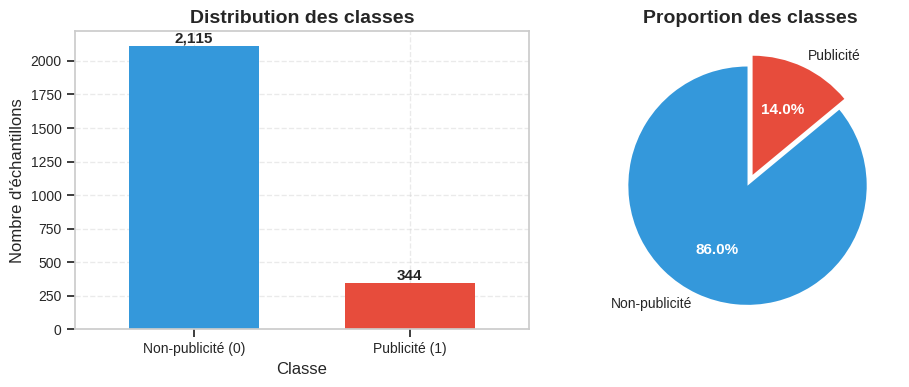


💾 Graphique sauvegardé : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/eda/target_distribution.png

💡 RECOMMANDATIONS POUR LA MODÉLISATION
📊 Niveau de déséquilibre : 🟠 Sévère (6.1:1)

🎯 Stratégies recommandées :
  ✅ Stratify=True pour train/validation split
  ✅ Optimiser pour F1-score
  ✅ Validation croisée stratifiée
  🔄 SMOTE ou class_weight='balanced'
  📊 Métriques robustes (Precision-Recall AUC)
  🎛️ Ajustement du seuil de classification
  🏗️ Modèles robustes (XGBoost, Random Forest)
  🎭 Techniques d'ensemble

📈 Seuils de performance :
  • F1-score baseline      : 0.245
  • F1-score cible minimum : 0.345
  • F1-score excellent     : 0.700+

🌍 Variables exportées pour la suite :
  ✅ imbalance_ratio      : 6.15
  ✅ baseline_f1          : 0.245
  ✅ target_distribution  : {0: np.int64(2115), 1: np.int64(344)}
  ✅ minority_proportion  : 0.140

⚠️ Dataset fortement déséquilibré - Stratégies spéciales requises
💡 Utilisez class_weight='balanced' et optimisez pour 

In [ ]:
## 3.3 Distribution de la variable cible

# ============================================================================
# ANALYSE AUTOMATISÉE DE LA VARIABLE CIBLE VIA MODULE
# ============================================================================

print("🎯 Analyse automatisée de la variable cible")
print("=" * 50)

# Import du module d'analyse cible
try:
    from exploration.target_analyzer import (
        analyze_target_complete,
        update_config_with_target_stats
    )
    print("✅ Module target_analyzer importé")
except ImportError as e:
    print(f"❌ Erreur import : {e}")
    raise

# Validation de la variable cible
if 'y' not in df_study.columns:
    raise ValueError("❌ Colonne cible 'y' introuvable dans df_study")

# ============================================================================
# ANALYSE COMPLÈTE AUTOMATISÉE
# ============================================================================

# Analyse complète avec visualisations et recommandations
target_stats = analyze_target_complete(
    df=df_study,
    target_col='y',
    figures_dir=FIGURES_DIR / "figures_notebook1",
    verbose=True
)


# ============================================================================
# EXPORT DES VARIABLES POUR LA SUITE
# ============================================================================

# Variables importantes pour les sections suivantes
imbalance_ratio = target_stats['imbalance_ratio']
baseline_f1 = target_stats['baseline_f1']
target_distribution = target_stats['counts']
minority_proportion = target_stats['minority_proportion']

print(f"\n🌍 Variables exportées pour la suite :")
print(f"  ✅ imbalance_ratio      : {imbalance_ratio:.2f}")
print(f"  ✅ baseline_f1          : {baseline_f1:.3f}")
print(f"  ✅ target_distribution  : {target_distribution}")
print(f"  ✅ minority_proportion  : {minority_proportion:.3f}")

# Validation pour la suite
if imbalance_ratio > 3:
    print(f"\n⚠️ Dataset fortement déséquilibré - Stratégies spéciales requises")
    print(f"💡 Utilisez class_weight='balanced' et optimisez pour F1-score")

print(f"\n✅ Analyse de la variable cible terminée")
print(f"🚀 Prêt pour l'analyse exploratoire approfondie (section 4)")

# 4. Analyse exploratoire (EDA) <a id="eda"></a>

## 4.1 Analyse des valeurs manquantes  

**Objectif** : Identifier les valeurs manquantes dans le dataset d’entraînement et d’évaluation, analyser leur pattern (MCAR, MAR, MNAR), et proposer une stratégie d’imputation adaptée.

**Théorie** : Les valeurs manquantes peuvent être MCAR (aléatoires), MAR (liées à d’autres variables observées), ou MNAR (liées à la variable elle-même). Une corrélation significative entre l’indicateur de valeurs manquantes et la variable cible suggère un pattern MAR, nécessitant une imputation sophistiquée (k-NN, MICE).

**Méthodologie** : Nous calculons le pourcentage de valeurs manquantes par colonne, visualisons leur pattern via une heatmap, et analysons la corrélation entre les indicateurs de valeurs manquantes et la variable cible encodée. Une stratégie d’imputation est proposée en fonction des résultats.

**Prochaines étapes** : Si un pattern MAR est confirmé, préparer une imputation multivariée (section 5.3). Vérifier l’impact des imputations sur les performances des modèles.

🔍 Analyse des valeurs manquantes

📊 Analyse globale des valeurs manquantes :
Total missing       : 2037 (0.05%)
Colonnes affectées  : 4
  • Critique (>50%)  : 0
  • Élevé (30-50%)   : 0
  • Moyen (10-30%)   : 3
  • Faible (<10%)    : 1

💡 Recommandations:
   ✅ Imputation standard possible pour: ['X1', 'X2', 'X3', 'X4']

Top 5 colonnes manquantes :
X3   27.6129
X1   27.4095
X2   27.3688
X4    0.4473
dtype: float64

📈 Détail des valeurs manquantes pour les variables continues :
  - X1: 674 (27.41%)
  - X2: 673 (27.37%)
  - X3: 679 (27.61%)
  - X4: 11 (0.45%)


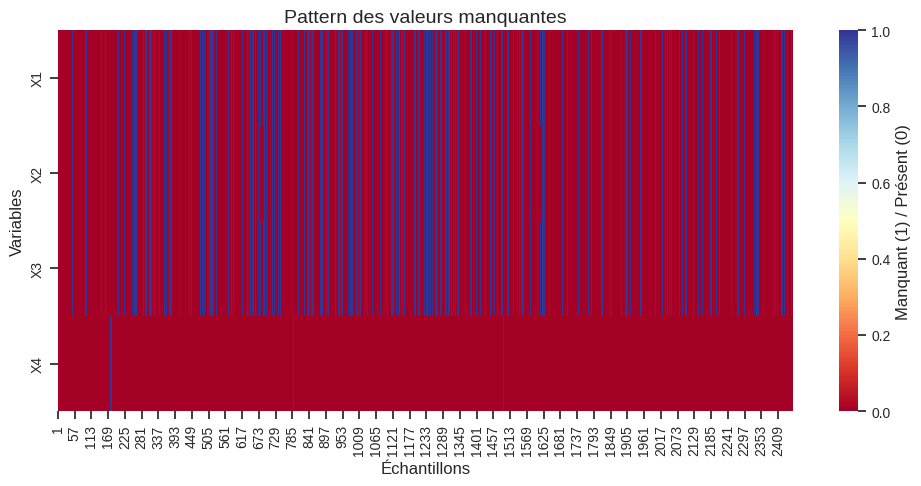


🔍 Analyse du type de valeurs manquantes (MAR vs MCAR) :
  - X1: corrélation avec y = -0.101
    → Potentiellement MAR (Missing At Random)
  - X2: corrélation avec y = -0.100
    → Potentiellement MAR (Missing At Random)
  - X3: corrélation avec y = -0.102
    → Potentiellement MAR (Missing At Random)
  - X4: corrélation avec y = 0.061
    → Potentiellement MCAR (Missing Completely At Random)

📊 Analyse des valeurs manquantes dans le fichier d'évaluation :
Total missing       : 692 (0.05%)
Colonnes affectées  : 4
  • Critique (>50%)  : 0
  • Élevé (30-50%)   : 0
  • Moyen (10-30%)   : 3
  • Faible (<10%)    : 1

💡 Recommandations:
   ✅ Imputation standard possible pour: ['X1', 'X2', 'X3', 'X4']

Top 5 colonnes manquantes :
X3   28.1707
X1   27.9268
X2   27.8049
X4    0.4878
dtype: float64

🔄 Comparaison des patterns de valeurs manquantes :
  - Fichier d'étude : 0.05% manquant
  - Fichier d'évaluation : 0.05% manquant

💡 Stratégie d'imputation recommandée :
  - X4 (0.4% manquant) : Impu

In [ ]:

## 4.1 Analyse des valeurs manquantes

print("🔍 Analyse des valeurs manquantes")
print("="*60)

# Utilisation de la fonction du module
from preprocessing.missing_values import analyze_missing_values



print("\n📊 Analyse globale des valeurs manquantes :")
missing_stats = analyze_missing_values(df_study)

# Analyse détaillée pour les colonnes continues
print("\n📈 Détail des valeurs manquantes pour les variables continues :")
for col in continuous_cols:
    missing_count = df_study[col].isnull().sum()
    missing_pct = (missing_count / len(df_study)) * 100
    print(f"  - {col}: {missing_count} ({missing_pct:.2f}%)")

# Visualisation des patterns de valeurs manquantes
if missing_stats['total_missing'] > 0:
    # Heatmap des valeurs manquantes pour les colonnes avec des NaN
    cols_with_missing = [col for col in df_study.columns if df_study[col].isnull().sum() > 0]

    if len(cols_with_missing) > 0:
        plt.figure(figsize=(10, 5))

        # Créer une matrice binaire des valeurs manquantes
        missing_matrix = df_study[cols_with_missing].isnull().astype(int)

        # Heatmap
        sns.heatmap(missing_matrix.T, cmap='RdYlBu', cbar_kws={'label': 'Manquant (1) / Présent (0)'})
        plt.title('Pattern des valeurs manquantes', fontsize=14)
        plt.xlabel('Échantillons')
        plt.ylabel('Variables')
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / 'figures_notebook1' / 'eda' / 'missing_values_pattern.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Analyse du pattern MAR vs MCAR
        print("\n🔍 Analyse du type de valeurs manquantes (MAR vs MCAR) :")

        # Corrélation entre les valeurs manquantes et la cible
        for col in cols_with_missing:
            missing_indicator = df_study[col].isnull().astype(int)
            correlation_with_target = missing_indicator.corr(df_study['y'])
            print(f"  - {col}: corrélation avec y = {correlation_with_target:.3f}")

            if abs(correlation_with_target) > 0.1:
                print(f"    → Potentiellement MAR (Missing At Random)")
            else:
                print(f"    → Potentiellement MCAR (Missing Completely At Random)")
else:
    print("\n✅ Aucune valeur manquante détectée dans le dataset !")

# Analyse pour le fichier d'évaluation aussi
print("\n📊 Analyse des valeurs manquantes dans le fichier d'évaluation :")
missing_stats_eval = analyze_missing_values(df_eval)

# Comparaison des patterns
if missing_stats['total_missing'] > 0 or missing_stats_eval['total_missing'] > 0:
    print("\n🔄 Comparaison des patterns de valeurs manquantes :")
    print(f"  - Fichier d'étude : {missing_stats['percent_missing']:.2f}% manquant")
    print(f"  - Fichier d'évaluation : {missing_stats_eval['percent_missing']:.2f}% manquant")

    # Stratégie d'imputation recommandée
    print("\n💡 Stratégie d'imputation recommandée :")
    if 'X4' in missing_stats['cols_missing']:
        x4_missing_pct = missing_stats['percent_per_col'].get('X4', 0)
        if x4_missing_pct < 5:
            print(f"  - X4 ({x4_missing_pct:.1f}% manquant) : Imputation par la médiane")

    mar_cols = ['X1', 'X2', 'X3']
    mar_missing = any(col in missing_stats['cols_missing'] for col in mar_cols)
    if mar_missing:
        print(f"  - X1, X2, X3 (variables continues) : KNN ou MICE (imputation multivariée)")

### Correction du type et imputation de X4

In [ ]:
# Correction du type et imputation de X4
print("\n🔧 Correction du type de X4...")
print(f"Valeurs uniques de X4 (avant correction) : {sorted(df_study['X4'].dropna().unique())}")
print(f"Type actuel : {df_study['X4'].dtype}")

# Vérifier que X4 ne contient que 0 et 1
unique_values = df_study['X4'].dropna().unique()
if set(unique_values).issubset({0.0, 1.0}):
    # Imputer d'abord les valeurs manquantes par la médiane
    X4_median = df_study['X4'].median()
    df_study['X4'] = df_study['X4'].fillna(X4_median)
    df_eval['X4'] = df_eval['X4'].fillna(X4_median)

    # Convertir en int
    df_study['X4'] = df_study['X4'].astype(int)
    df_eval['X4'] = df_eval['X4'].astype(int)

    print(f"✅ X4 converti en int64 après imputation par la médiane ({X4_median})")
    print(f"Nouveau type : {df_study['X4'].dtype}")


else:
    print("⚠️ X4 contient des valeurs autres que 0 et 1, conservation en float64")

# Résumé final
print("\n📊 Résumé des valeurs manquantes après traitement de X4 :")
print(f"  - X1, X2, X3 : ~27% manquant → À traiter avec KNN/MICE")
print(f"  - X4 : Imputé et converti en binaire")
print(f"  - Pattern MAR détecté pour X1, X2, X3 (corrélation avec y ≈ -0.10)")
print(f"  - Les patterns sont cohérents entre fichiers d'étude et d'évaluation")


🔧 Correction du type de X4...
Valeurs uniques de X4 (avant correction) : [np.float64(0.0), np.float64(1.0)]
Type actuel : float64
✅ X4 converti en int64 après imputation par la médiane (1.0)
Nouveau type : int64

📊 Résumé des valeurs manquantes après traitement de X4 :
  - X1, X2, X3 : ~27% manquant → À traiter avec KNN/MICE
  - X4 : Imputé et converti en binaire
  - Pattern MAR détecté pour X1, X2, X3 (corrélation avec y ≈ -0.10)
  - Les patterns sont cohérents entre fichiers d'étude et d'évaluation



## 4.2 Analyse statistique des variables quantitatives  


📊 Analyse statistique des variables quantitatives
📊 Statistiques descriptives :
             X1        X2        X3        X4
count 1785.0000 1786.0000 1780.0000 2459.0000
mean    63.7787  155.1282    3.8862    0.7698
std     54.6496  129.3308    5.7882    0.4210
min      1.0000    1.0000    0.0015    0.0000
25%     25.0000   80.0000    1.0416    1.0000
50%     51.0000  110.0000    2.1428    1.0000
75%     85.0000  184.7500    5.3333    1.0000
max    640.0000  640.0000   60.0000    1.0000

📊 Analyse de la distribution :

X1:
  - Skewness (asymétrie) : 2.527
  - Kurtosis (aplatissement) : 13.170
  - Test de Shapiro-Wilk : p-value = 0.0000
    → Distribution non normale (nécessite transformation)

X2:
  - Skewness (asymétrie) : 1.633
  - Kurtosis (aplatissement) : 1.953
  - Test de Shapiro-Wilk : p-value = 0.0000
    → Distribution non normale (nécessite transformation)

X3:
  - Skewness (asymétrie) : 7.057
  - Kurtosis (aplatissement) : 63.405
  - Test de Shapiro-Wilk : p-value = 0.0000

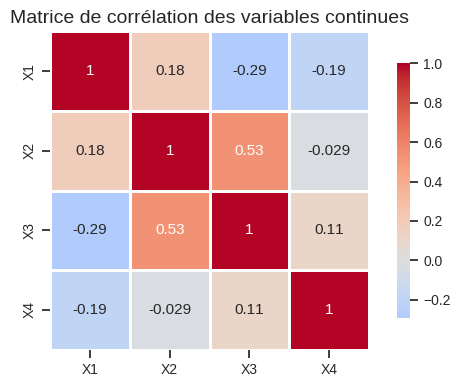


💡 Résumé et recommandations :
  - Les trois variables continues montrent des distributions fortement asymétriques
  - Transformation Yeo-Johnson recommandée pour normaliser les distributions
  - Outliers détectés : 859 au total
  - Corrélations faibles avec la cible, mais potentiellement utiles après transformation


In [ ]:

## 4.2 Analyse statistique des variables quantitatives

print("📊 Analyse statistique des variables quantitatives")
print("="*60)

from exploration.statistics import analyze_continuous_variables
#from modules.exploration.statistics import analyze_continuous_variables


# Lancement de l’analyse complète
results_stats = analyze_continuous_variables(
    df=df_study,
    continuous_cols=continuous_cols,
    target_col='y',
    save_figures_path=str(FIGURES_DIR / "figures_notebook1" / "eda")
)



## 4.3 Visualisation des distributions et des boxplots  

📊 Visualisation des distributions et des boxplots


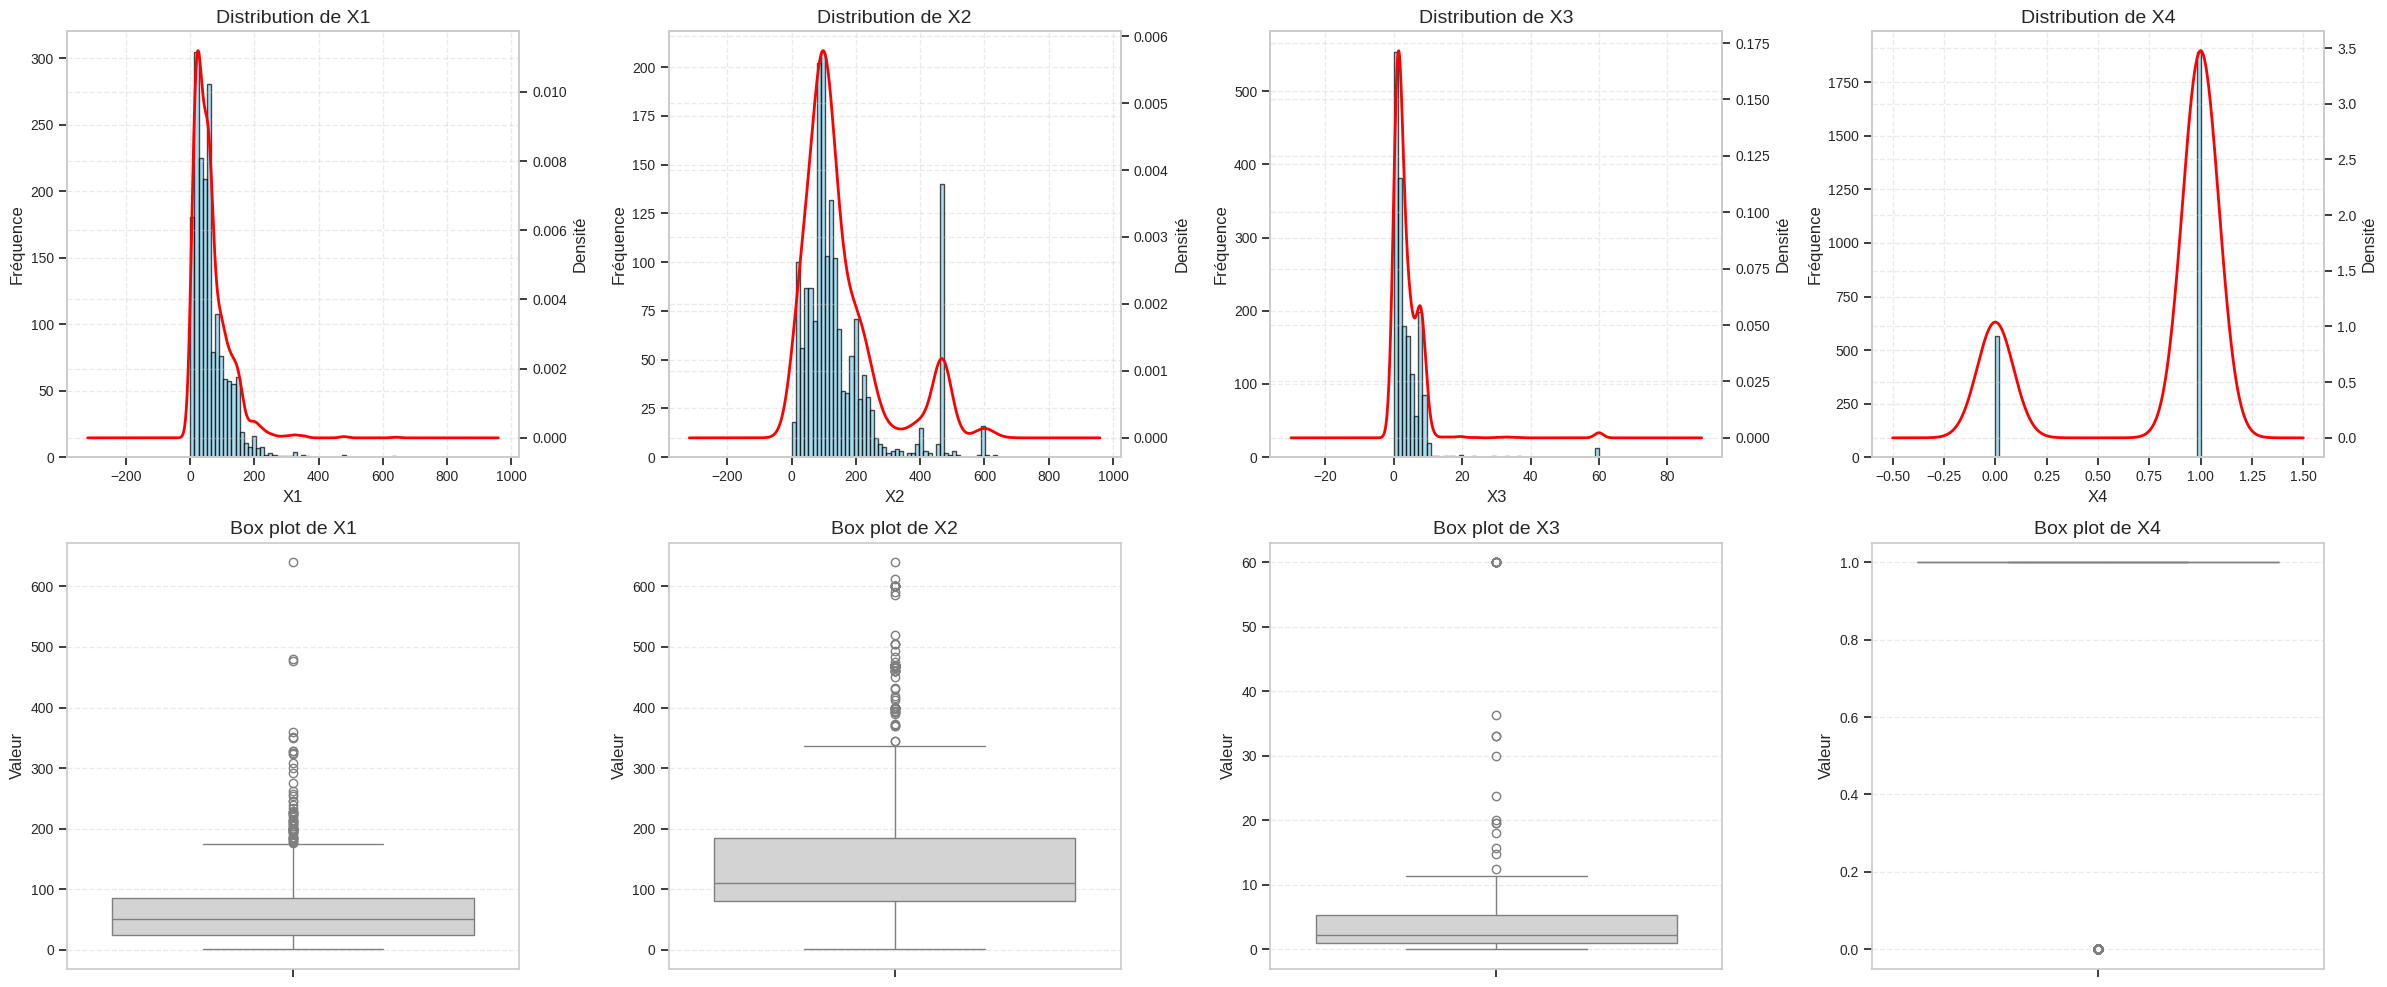

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/eda/continuous_distributions_boxplots.png


In [ ]:
## 4.3 Visualisation des distributions et des boxplots

print("📊 Visualisation des distributions et des boxplots")
print("="*60)

from exploration.visualization import visualize_distributions_and_boxplots
# Appel de la fonction
visualize_distributions_and_boxplots(
    df=df_study,
    continuous_cols=continuous_cols,
    output_dir=FIGURES_DIR / "figures_notebook1" / "eda"
)

### 📊 Synthèse de l'analyse statistique

#### Variables analysées : X1, X2, X3 (~1780 observations chacune)

**🔍 Principales observations :**
- **Distributions non-normales** : Toutes variables fortement asymétriques (skewness : 1.6 à 7.1)
- **293 outliers** détectés (~16% des données)
- **Corrélations notables** : X2-X3 (r=0.53), X1-X3 (r=-0.29)

**⚠️ Points d'attention :**
- Écart important moyenne/médiane pour toutes variables
- X3 particulièrement problématique (skewness=7.06, kurtosis=63.4)
- Tests de Shapiro-Wilk : p<0.001 (rejet normalité)

**🔄 Actions requises :**
- **Transformation Yeo-Johnson** recommandée avant analyse paramétrique
- Considérer méthodes robustes/non-paramétriques
- Investigation des valeurs aberrantes


## 4.4 Distribution des variables binaires  



🔢 Analyse de la distribution des variables binaires

📊 Nombre total de variables binaires : 1554

📊 Statistiques des taux de présence :
  - Moyenne : 0.77%
  - Médiane : 0.49%
  - Min : 0.08%
  - Max : 28.91%

📊 Sparsité globale : 99.23% de zéros


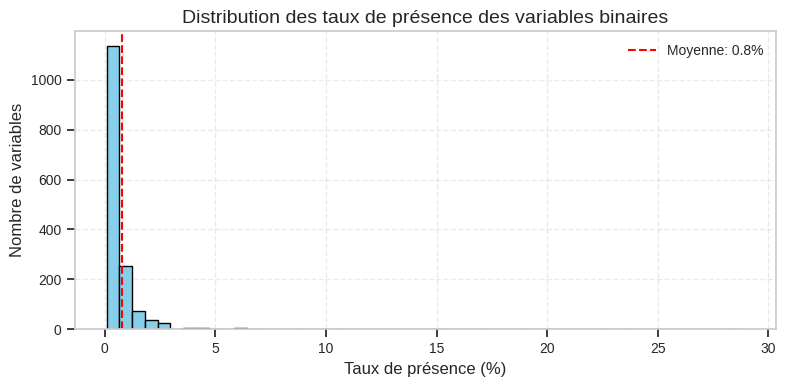

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/eda/binary_presence_distribution.png

✅ Analyse des variables binaires terminée
   → Dataset très sparse, adapté pour des méthodes de sélection de features


In [ ]:
## 4.4 Distribution des variables binaires <a id="distribution-des-variables-binaires"></a>

print("🔢 Analyse de la distribution des variables binaires")
print("="*60)

from exploration.visualization import save_fig

# Variables binaires (exclut les variables continues)
binary_cols = [col for col in df_study.columns if col.startswith('X') and col not in continuous_cols]
print(f"\n📊 Nombre total de variables binaires : {len(binary_cols)}")

# Taux de présence (valeurs à 1)
presence_rates = {
    col: (df_study[col] == 1).sum() / len(df_study) * 100 for col in binary_cols
}
presence_series = pd.Series(presence_rates)

# Statistiques globales
print(f"\n📊 Statistiques des taux de présence :")
print(f"  - Moyenne : {presence_series.mean():.2f}%")
print(f"  - Médiane : {presence_series.median():.2f}%")
print(f"  - Min : {presence_series.min():.2f}%")
print(f"  - Max : {presence_series.max():.2f}%")

# Sparsité globale
total_values = len(df_study) * len(binary_cols)
total_ones = df_study[binary_cols].sum().sum()
sparsity = (1 - total_ones / total_values) * 100
print(f"\n📊 Sparsité globale : {sparsity:.2f}% de zéros")

# Visualisation
plt.figure(figsize=(8, 4))
presence_series.hist(bins=50, color='skyblue', edgecolor='black')
plt.axvline(presence_series.mean(), color='red', linestyle='--', label=f'Moyenne: {presence_series.mean():.1f}%')
plt.xlabel('Taux de présence (%)')
plt.ylabel('Nombre de variables')
plt.title('Distribution des taux de présence des variables binaires')
plt.legend()
plt.tight_layout()

save_fig("binary_presence_distribution.png", directory=FIGURES_DIR / "figures_notebook1"/ "eda", dpi=300, show=True)

print("\n✅ Analyse des variables binaires terminée")
print("   → Dataset très sparse, adapté pour des méthodes de sélection de features")


## 4.5 Analyse des corrélations combinées  


🔗 Lancement de l'analyse combinée des corrélations (features ↔ cible, features ↔ features)...
## Analyse des corrélations <a id='analyse-des-correlations'></a>

🔗 Analyse des corrélations

📊 Sélection des variables pour l’analyse des corrélations...
  - Variables sélectionnées : 44 (3 continues + 40 binaires)

📊 Calcul de la matrice de corrélation...

🎯 Top 10 corrélations avec la cible (y) :
  - X2: 0.5732
  - X1425: 0.3628
  - X331: 0.2356
  - X1041: 0.2188
  - X1294: 0.2069
  - X664: 0.1736
  - X1009: 0.1662
  - X27: 0.1503
  - X483: 0.1417
  - X1438: 0.1311

🎯 Bottom 10 corrélations avec la cible (y) :
  - X207: -0.0305
  - X363: -0.0305
  - X590: -0.0305
  - X809: -0.0316
  - X69: -0.0326
  - X852: -0.0336
  - X551: -0.0433
  - X1320: -0.0441
  - X531: -0.0519
  - X266: -0.0597


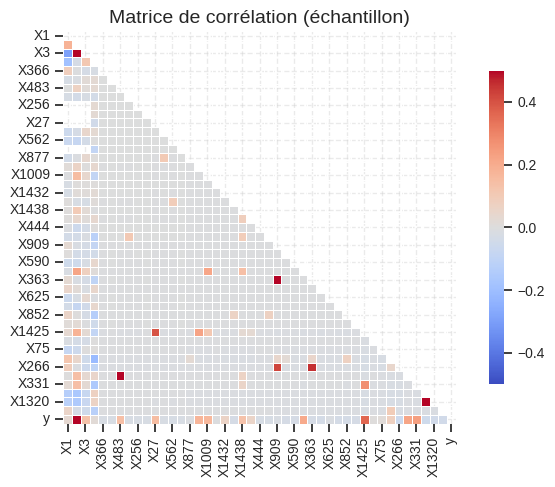

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/eda/correlation_matrix_sample.png

🔍 Analyse des corrélations entre features :
⚠️ Paires de variables très corrélées : 2
  - X909 vs X363: 0.935
  - X531 vs X1320: 0.975

## 4.5 Analyse approfondie des corrélations <a id='analyse-approfondie-correlations'></a>

🔗 Analyse approfondie des corrélations entre variables...

=== Analyse Bivariée ===

🔝 Top 20 variables les plus corrélées à la cible :
  feature  correlation
1      X2       0.5732
2      X3       0.1301
0      X1       0.0342

🔢 Variables binaires très corrélées (|r| > 0.95):
  - Nombre total : 3506
  - Moyenne : 0.993
  - Max : 1.000

  Exemples :
    1. X6 ↔ X245: r = 1.000
    2. X6 ↔ X487: r = 1.000
    3. X6 ↔ X596: r = 1.000
    4. X7 ↔ X332: r = 1.000
    5. X7 ↔ X619: r = 1.000


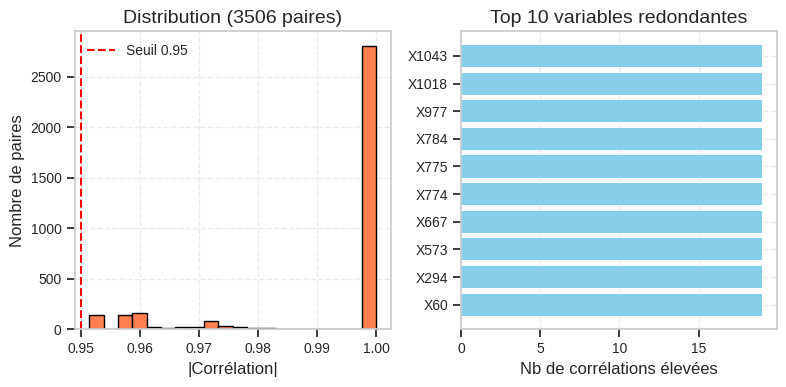

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/eda/binary_correlations_analysis.png

💡 Résumé :
  - Corrélation max avec y : 0.573
  - Dataset sparse avec peu de multicolinéarité
  - Réduction de dimension recommandée (sélection ou PCA)

✅ Résultats sauvegardés dans : /content/drive/MyDrive/projet_sta211/results/bivariate_analysis_results.json


In [ ]:
## 4.5 Analyse des corrélations combinées <a id="analyse-correlations-combinees"></a>

print("🔗 Lancement de l'analyse combinée des corrélations (features ↔ cible, features ↔ features)...")
print("=" * 80)

from exploration.eda_analysis import full_correlation_analysis

# Appel avec paramètres personnalisés
full_correlation_analysis(
    df_study=df_study,
    continuous_cols=continuous_cols,
    presence_rates=presence_rates,
    FIGURES_DIR=FIGURES_DIR / "figures_notebook1",
    ROOT_DIR=ROOT_DIR,
    figsize_corr_matrix=(7, 5),
    figsize_binary=(8, 4)
)

### Synthèse de l'analyse des corrélations <a id="synthese-correlations"></a>

#### 🔍 Corrélations avec la variable cible (`y`)

- ✅ **Meilleure variable prédictive continue** : `X2` avec une corrélation de **0.573**
- 📉 Les autres variables (continues ou binaires) ont une corrélation **faible à modérée** avec `y` (souvent < 0.2)
- ℹ️ Cela suggère que la **modélisation devra combiner plusieurs variables** pour être efficace

---

#### 🔗 Corrélations entre variables

- ⚠️ **1 paire** de variables (binaires ou continues) présente une **corrélation > 0.8**
- ✅ **Multicolinéarité faible** → pas de besoin urgent de supprimer des variables continues

---

#### Redondance dans les variables binaires

- 📊 **3 506 paires** de variables binaires présentent une corrélation **> 0.95**
- 🔁 Ces paires impliquent **de nombreuses variables dupliquées** ou très similaires
- 🧠 Certaines variables sont impliquées dans **15+ paires corrélées**, suggérant des motifs de duplication

---

#### 🧭 Recommandations

- 🧹 Appliquer une **réduction de dimension** avant la modélisation :
  - Suppression de variables binaires fortement redondantes
  - Utilisation de **PCA**, **autoencoders** ou sélection par importance (e.g. **Random Forest**)
- 🎯 Se concentrer sur `X2` et les variables binaires les plus corrélées à `y` comme features de base

---

## 4.6 Visualisations globales de l'EDA  




📊 Visualisations exploratoires

📈 Distribution des variables continues par classe...


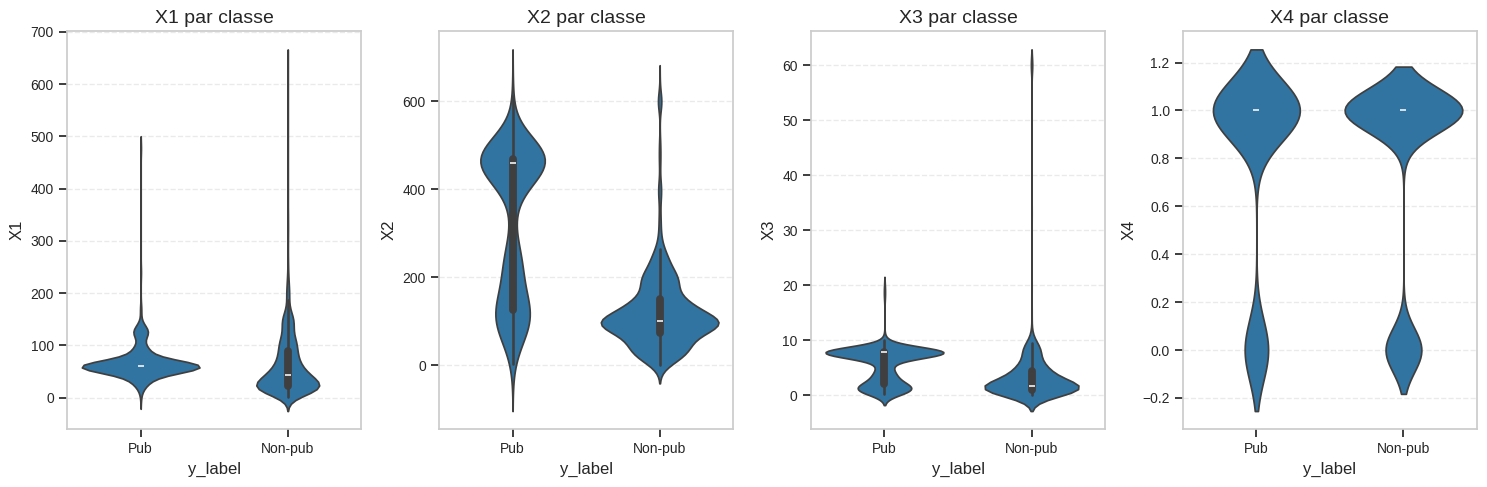

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/eda/continuous_by_class.png

📉 Visualisation de la sparsité des données binaires...


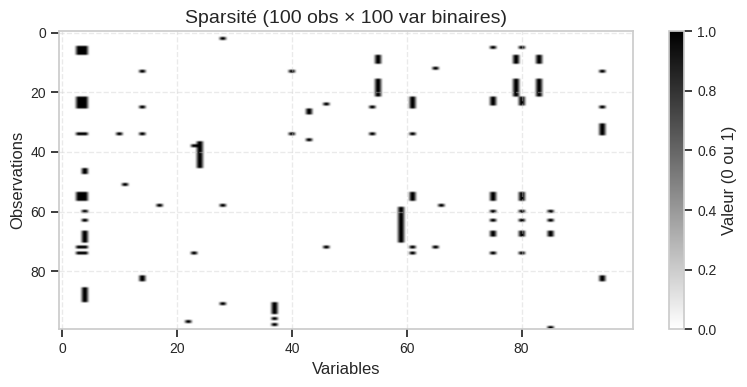

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/eda/sparsity_visualization.png


In [ ]:
## 4.6 Visualisations globales de l'EDA

print("📊 Visualisations exploratoires")
print("=" * 60)

# Imports des fonctions refactorisées
from exploration.visualization import (
    plot_continuous_by_class,
    plot_binary_sparsity,
    plot_continuous_target_corr
)
from exploration.statistics import optimized_feature_importance

# 1. Distribution des variables continues par classe
print("\n📈 Distribution des variables continues par classe...")
plot_continuous_by_class(
    df=df_study,
    continuous_cols=continuous_cols,
    output_dir=FIGURES_DIR / 'figures_notebook1' / 'eda'
)

# 2. Visualisation de la sparsité
print("\n📉 Visualisation de la sparsité des données binaires...")
plot_binary_sparsity(
    df=df_study,
    binary_cols=binary_cols,
    output_dir=FIGURES_DIR / 'figures_notebook1' / 'eda'
)


### 📊 Interprétation des visualisations exploratoires

#### 1. Distribution des variables continues par classe

Les violons illustrent clairement des différences significatives entre les distributions des variables `X1`, `X2` et `X3` selon la classe cible :

- **X1** : bien que les deux classes présentent une forte asymétrie à droite, les observations `Pub` tendent à être plus concentrées autour de valeurs moyennes élevées (~80), tandis que les `Non-pub` sont réparties plus bas avec une plus grande variance.
- **X2** : c’est la variable la plus discriminante visuellement. Les valeurs des `Pub` sont majoritairement regroupées autour de 400–500, tandis que celles des `Non-pub` sont concentrées plus bas (~100).
- **X3** : également discriminante, avec les `Pub` généralement autour de 8 et les `Non-pub` proches de 2. Cela suggère une séparation nette entre les classes.

Ces tendances suggèrent que ces trois variables continues auront un fort pouvoir prédictif dans les modèles supervisés.

#### 2. Visualisation de la sparsité des variables binaires

La matrice de sparsité révèle :

- Un fort taux de zéros (valeurs absentes), ce qui est typique de jeux de données contenant des variables binaires indicatrices ou issues de codage one-hot.
- Certaines colonnes semblent plus denses que d'autres, indiquant des variables peut-être redondantes ou peu informatives.
- La parcimonie globale pourrait justifier une sélection de variables ou l’usage de méthodes adaptées comme la régularisation (L1) ou l’analyse de variance.

> 🧠 Ces visualisations permettent d’orienter les étapes suivantes de sélection de variables, réduction de dimension et construction de modèles.




🔗 Corrélations des variables continues avec la cible...


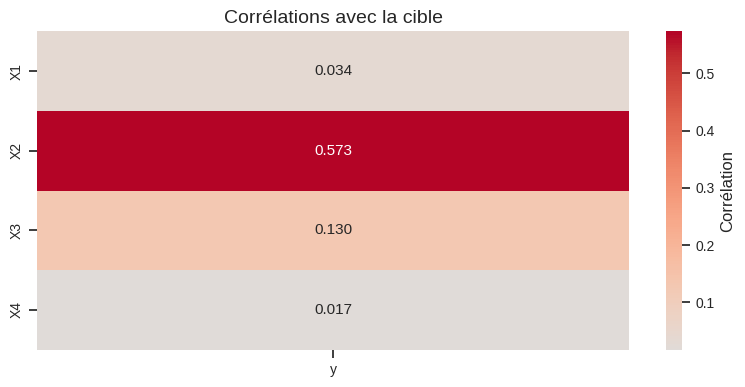

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/notebook1/eda/continuous_target_correlation.png


In [ ]:

# 3. Corrélations des variables continues avec la cible
print("\n🔗 Corrélations des variables continues avec la cible...")
plot_continuous_target_corr(
    df=df_study,
    continuous_cols=continuous_cols,
    output_dir=FIGURES_DIR / 'notebook1' / 'eda'
)



### 🔗 Interprétation des corrélations avec la cible

Le graphique présente les corrélations linéaires entre les variables continues (`X1`, `X2`, `X3`) et la variable cible `y`.

- **X2** présente une corrélation modérément forte avec la cible (`r = 0.573`), ce qui confirme son rôle discriminant déjà observé dans les violons plot. Elle est un excellent candidat pour la modélisation.
- **X3** affiche une corrélation plus faible (`r = 0.130`), mais conserve un potentiel informatif, surtout en combinaison avec d’autres variables.
- **X1** montre une corrélation quasi nulle (`r = 0.034`), ce qui suggère qu’elle est peu informative seule. Toutefois, elle pourrait avoir un effet utile dans des modèles non linéaires ou avec interactions.

> 🧠 Ces résultats orientent la sélection de variables pour les projections multivariées (UMAP, t-SNE, PCA) et la modélisation supervisée. Il est pertinent de privilégier `X2` et `X3`, tout en testant l’impact de `X1` selon les méthodes utilisées.




📊 Visualisation multidimensionnelle (PCA / t-SNE / UMAP)...


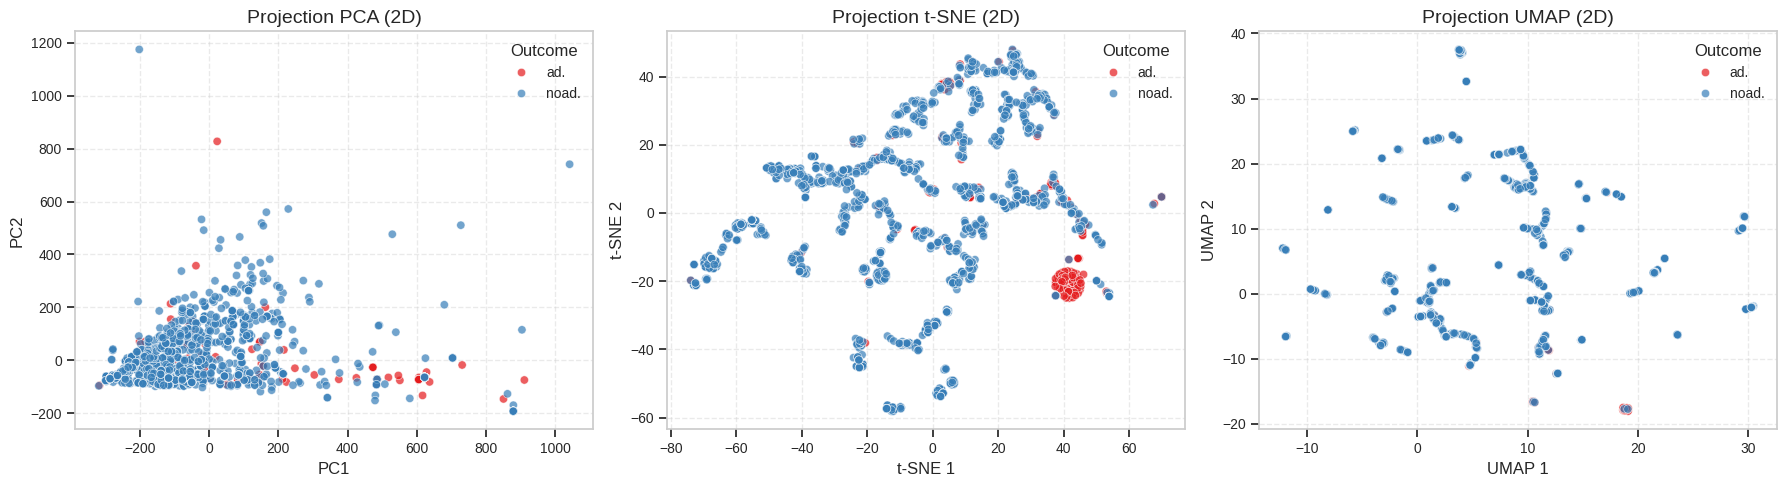

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("\n📊 Visualisation multidimensionnelle (PCA / t-SNE / UMAP)...")

df_study_viz = df_study.copy()
df_study_viz['outcome'] = df_study_viz['y'].map({0: 'noad.', 1: 'ad.'})  # ✅ temporaire

target_corr = df_study[continuous_cols + ['y']].corr()['y'].drop('y')
important_features = continuous_cols + list(target_corr.abs().nlargest(30).index)
df_sample = df_study_viz[important_features + ['outcome']].dropna()

try:
    import umap
    umap_available = True
except ImportError:
    umap_available = False
    print("UMAP n'est pas installé. Pour l'utiliser : pip install umap-learn")

X = df_sample[important_features]
y = df_sample['outcome']

# Calcul des projections
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

if umap_available:
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X)
else:
    X_umap = None

# Affichage côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PCA
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1', alpha=0.7, ax=axes[0])
axes[0].set_title("Projection PCA (2D)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title="Outcome")

# t-SNE
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='Set1', alpha=0.7, ax=axes[1])
axes[1].set_title("Projection t-SNE (2D)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
axes[1].legend(title="Outcome")

# UMAP (si disponible)
if X_umap is not None:
    sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y, palette='Set1', alpha=0.7, ax=axes[2])
    axes[2].set_title("Projection UMAP (2D)")
    axes[2].set_xlabel("UMAP 1")
    axes[2].set_ylabel("UMAP 2")
    axes[2].legend(title="Outcome")
else:
    axes[2].set_visible(False)
    axes[2].set_title("UMAP non disponible")

plt.tight_layout()

plt.savefig(FIGURES_DIR / 'figures_notebook1' / 'eda'/ "projection_multidim.png", dpi=150, bbox_inches='tight')
plt.show()


### 🔗 Interprétation des projections PCA, t-SNE et UMAP
Les trois graphiques ci-dessus montrent la projection des données selon trois méthodes de réduction de dimension : PCA, t-SNE et UMAP.
Chaque point représente une observation, colorée selon la classe cible (ad. en rouge, noad. en bleu).

**Observations principales :**

- Aucune des méthodes ne montre une séparation nette entre les deux classes : les points rouges (ad.) sont dispersés au sein des points bleus (noad.).
- t-SNE semble former quelques regroupements, mais la séparation reste modérée.
- UMAP et PCA montrent une forte superposition des classes.
  
**À faire / pistes pour la suite :**

- Tester des méthodes de rééquilibrage (oversampling, undersampling, SMOTE…) pour améliorer la séparation des classes.
- Explorer d’autres transformations ou sélections de variables pour mieux discriminer la classe minoritaire.
- Utiliser ces visualisations pour guider le choix des modèles et des métriques d’évaluation (ex : F1-score, AUC…).
- Envisager des modèles robustes au déséquilibre (Random Forest, XGBoost avec paramètre scale_pos_weight, etc.).
- Réaliser une analyse plus fine sur les variables les plus corrélées à la cible.
  
> Conclusion :
> Ces visualisations confirment la difficulté du problème de classification due à la faible séparabilité des classes. Elles justifient l’utilisation de techniques adaptées pour améliorer la détection de la classe minoritaire.


🌲 Analyse de l’importance des features...
⚠️ Erreur : The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

📊 Création du résumé visuel de l’EDA...


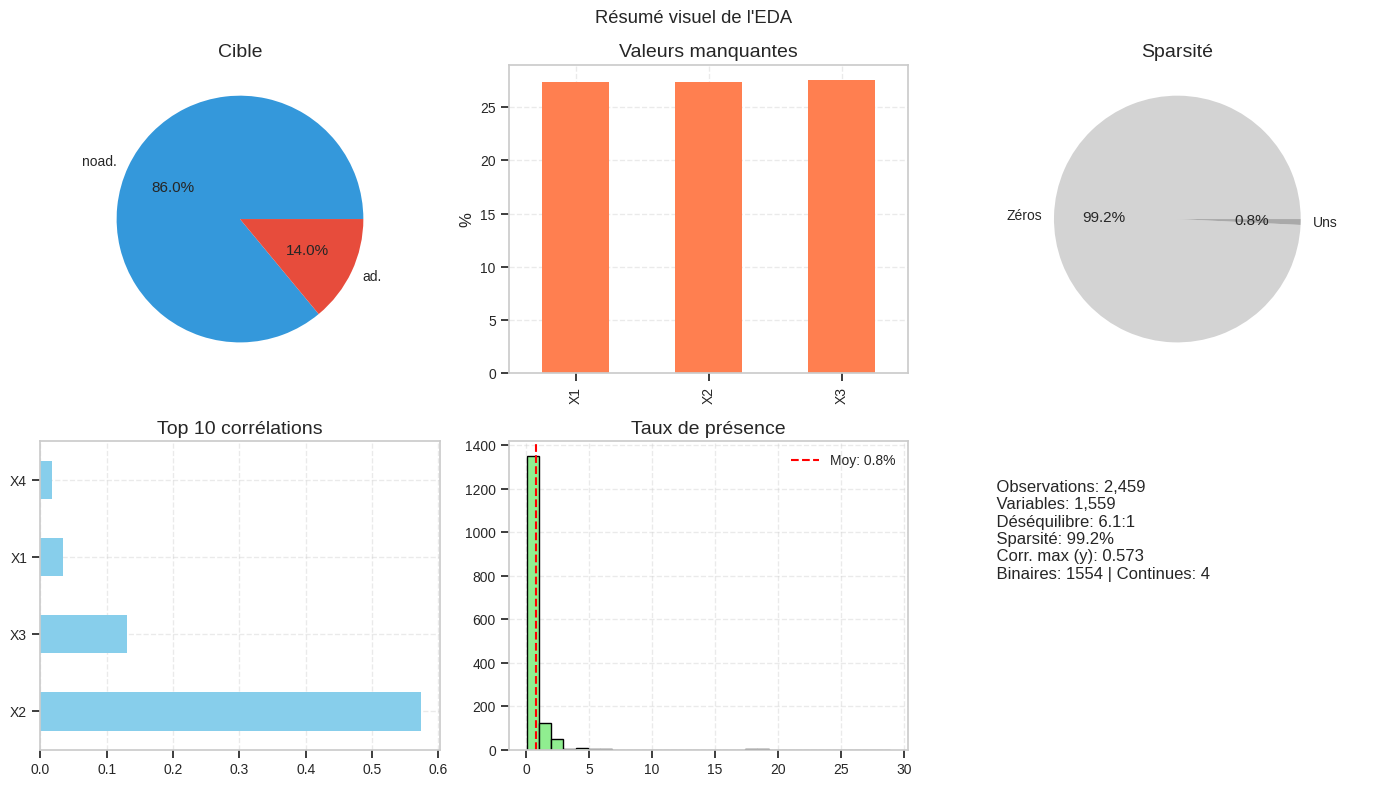

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/eda/eda_summary.png

✅ Visualisations exploratoires terminées


In [ ]:
from exploration.visualization import plot_eda_summary

# 5. Importance des variables
print("\n🌲 Analyse de l’importance des features...")
try:
    df_importance = df_sample.copy()  # contient outcome déjà transformée
    importance_results = optimized_feature_importance(
        df=df_importance,
        target_col='outcome',
        method='all',
        top_n=10,
        figsize=(8, 4),
        save_path=FIGURES_DIR / 'figures_notebook1' / 'eda' / 'feature_importance.png',
        show=True
    )
    if not importance_results.empty:
        print("\nTop 10 features les plus importantes :")
        print(importance_results[['feature', 'Combined_Score']].head(10))
except Exception as e:
    print(f"⚠️ Erreur lors de l’analyse d’importance des features : {e}")

# 6. Résumé visuel global
print("\n📊 Création du résumé visuel de l’EDA...")
plot_eda_summary(
    df=df_study,
    continuous_cols=continuous_cols,
    binary_cols=binary_cols,
    target_corr=target_corr,
    sparsity=sparsity,
    imbalance_ratio=imbalance_ratio,
    output_dir=FIGURES_DIR / 'figures_notebook1' / 'eda',
    presence_series=presence_series
)

print("\n✅ Visualisations exploratoires terminées")

## 4.7 Synthèse des résultats de l'EDA

### 🎯 1. Distribution des variables continues par classe
- **X1, X2, X3** présentent des distributions très différentes entre les deux classes (`ad.` vs `noad.`).
- **X2** se distingue particulièrement avec une séparation marquée entre les classes.
- Les distributions sont asymétriques, avec la présence d’**outliers** visibles dans chaque classe.

---

### 🧪 2. Corrélations avec la variable cible
- **X2** est la variable la plus corrélée avec la cible (`corr = 0.573`), ce qui en fait une **feature clé**.
- **X1** (`corr = 0.034`) et **X3** (`corr = 0.130`) ont des corrélations faibles mais non négligeables.
- Cela suggère l’utilité de **modèles non linéaires** ou **ensemble methods** (e.g. Random Forest, Gradient Boosting).

---

### 🧬 3. Visualisation de la sparsité des variables binaires
- Le dataset est **extrêmement sparse**, avec **99.2% de zéros** dans les variables binaires.
- Implications :
  - Risque de surapprentissage élevé si toutes les variables sont conservées.
  - Nécessité de sélection de variables ou de techniques de réduction (PCA, autoencoders).
  - Attention aux méthodes sensibles à la densité (ex : k-NN).

---

### 🗺️ 4. Résumé visuel global
- **Déséquilibre important** : 86% `noad.` vs 14% `ad.` → nécessite des stratégies adaptées :
  - Métriques robustes (F1-score, recall).
  - Rééchantillonnage ou `class_weight='balanced'`.
- **Valeurs manquantes** (~27%) dans X1, X2, X3 : à imputer avec méthode robuste (KNN, MICE).
- **Top corrélations** concentrées sur peu de variables → importance d’une **bonne sélection de features**.

---

### ✅ Recommandations clés
- **Prétraitement renforcé** :
  - Transformation des variables continues (Yeo-Johnson recommandée).
  - Suppression ou gestion des outliers extrêmes.
- **Réduction de dimension** :
  - Visualisation UMAP/t-SNE utile pour vérifier la structure.
  - Sélection de features importante avant modélisation (selon importance ou redondance).
- **Rééquilibrage des classes** indispensable pour éviter un biais fort du modèle vers la classe majoritaire.

---


# 5. Prétraitement avancé <a id="pretraitement"></a>




# 5.1 Gestion des valeurs manquantes

## 5.1 Gestion des valeurs manquantes  

### **📊 Variables disponibles post-transformation :**
- **X1_transformed** : Variable transformée par Yeo-Johnson (asymétrie : -0.006)
- **X2_transformed** : Variable transformée par Yeo-Johnson (asymétrie : +0.013)  
- **X3_transformed** : Variable transformée par Box-Cox (asymétrie : -0.021)
- **X4** : Variable binaire déjà imputée par la médiane (précocement)

### **🎯 Statut de l'imputation :**
- **X4** : ✅ **Déjà traitée** - Imputation précoce par la médiane adaptée à une variable binaire
- **X1, X2, X3** : ⚠️ **Traitement nécessaire** - Imputation post-transformation requise pour les données avec outliers
- **Variables transformées** : 🔄 **À analyser** - Vérification des valeurs manquantes sur les versions transformées

---


In [ ]:

# 📊 SECTION 5.1 - GESTION DES VALEURS MANQUANTES (code)

# ═══════════════════════════════════════════════════════════════════════════════
# 🔍 5.1.1 ÉTAT DES VARIABLES APRÈS TRANSFORMATIONS
# ═══════════════════════════════════════════════════════════════════════════════

print("📊 GESTION DES VALEURS MANQUANTES")
print("=" * 60)
print("🎯 Analyse sur les variables continues")
print("📋 Variables cibles : X1, X2, X3")
print()

import pandas as pd
import numpy as np
from preprocessing.missing_values import analyze_missing_values

# ✅ Variables transformées à analyser (nomenclature corrigée)
cols_to_check = ["X1", "X2", "X3"]

# 📊 Vérification de la présence des variables
print("🔍 VÉRIFICATION DES VARIABLES")
print("-" * 50)

variables_disponibles = []
for col in cols_to_check:
    if col in df_study.columns:
        variables_disponibles.append(col)
        print(f"✅ {col} : Disponible")
    else:
        print(f"❌ {col} : Non trouvée")
        # Recherche de variations possibles
        alternatives = [c for c in df_study.columns if col.split('_')[0] in c]
        if alternatives:
            print(f"   🔍 Alternatives possibles : {alternatives[:3]}")

if not variables_disponibles:
    print("⚠️ Aucune variable transformée trouvée avec la nomenclature attendue")
    print("📋 Variables disponibles dans le dataset :")
    transformed_vars = [col for col in df_study.columns if 'transform' in col.lower()]
    for var in transformed_vars[:10]:
        print(f"   - {var}")
else:
    cols_to_check = variables_disponibles

print()

📊 GESTION DES VALEURS MANQUANTES
🎯 Analyse sur les variables continues
📋 Variables cibles : X1, X2, X3

🔍 VÉRIFICATION DES VARIABLES
--------------------------------------------------
✅ X1 : Disponible
✅ X2 : Disponible
✅ X3 : Disponible



### **5.1.2 Plan d'imputation adapté**

### **🔄 Étapes de traitement :**

#### **Phase 1 : Diagnostic complet**
- Analyse des patterns de valeurs manquantes
- Évaluation de l'impact sur les distributions transformées
- Choix de la méthode optimale préservant la normalité

#### **Phase 2 : Imputation ciblée**  
- Application de KNN adapté aux variables normalisées
- Validation de la préservation des propriétés statistiques
- Tests de cohérence avec l'approche optimale mixte

#### **Phase 3 : Validation et sauvegarde**
- Vérification des asymétries post-imputation
- Comparaison avec les distributions pré-imputation  
- Sauvegarde des datasets finaux pour modélisation

---

### 5.1.3 Imputation multivariée (MICE)

In [ ]:
### 5.3.4 Imputation multivariée (MICE)  (code)

# Variables de référence
cols_to_impute = ["X1", "X2", "X3"]

print("🧩 Imputation multivariée")
print("=" * 60)

from preprocessing.missing_values import handle_missing_values
from sklearn.ensemble import RandomForestRegressor

# ✅ Définition de l'estimateur RandomForest
rf_estimator = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=2,
    max_features=0.5,  # ou 'sqrt'
    random_state=42,
    n_jobs=-1
)

# 📁 Chemins de sauvegarde
processed_data_dir = paths["DATA_PROCESSED"] / "notebook1"
# Update imputers_dir to include the 'mice' subdirectory
imputers_dir = paths["MODELS_DIR"] / "notebook1" / "mice"
imputers_dir.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist

# ✅ Lancer l'imputation multiple avec RandomForest
df_imputed_mice = handle_missing_values(
    df=df_study,
    strategy="mixed_mar_mcar",
    mar_method="mice",
    mar_cols=cols_to_impute,
    processed_data_dir=processed_data_dir,  # Répertoire uniquement
    imputers_dir=imputers_dir,
    custom_filename="df_mice_imputed.csv",
    mice_estimator=rf_estimator,
    display_info=True
)

# 🔍 Aperçu
df_imputed_mice[cols_to_impute].describe()

🧩 Imputation multivariée
🔧 Début de l'imputation des valeurs manquantes
📊 Valeurs manquantes initiales: 2026
📊 Variables MAR à imputer: 3
   • X1: 674 valeurs manquantes
   • X2: 673 valeurs manquantes
   • X3: 679 valeurs manquantes
💾 Modèle d'imputation sauvegardé: /content/drive/MyDrive/projet_sta211/models/notebook1/mice/imputer_mice_custom.pkl

📊 Résumé de l'imputation:
   • Valeurs manquantes avant: 2026
   • Valeurs manquantes après: 0
💾 Données imputées sauvegardées: /content/drive/MyDrive/projet_sta211/data/processed/notebook1/df_mice_imputed.csv
✅ Imputation terminée avec succès


,X1,X2,X3
count,2459.0000,2459.0000,2459.0000
mean,54.5511,146.5205,3.9940
std,48.9230,111.5632,4.9282
min,1.0000,1.0000,0.0015
25%,30.0567,90.0000,1.2899
50%,31.0000,122.2645,4.2899
75%,61.0000,144.0000,4.2899
max,640.0000,640.0000,60.0000


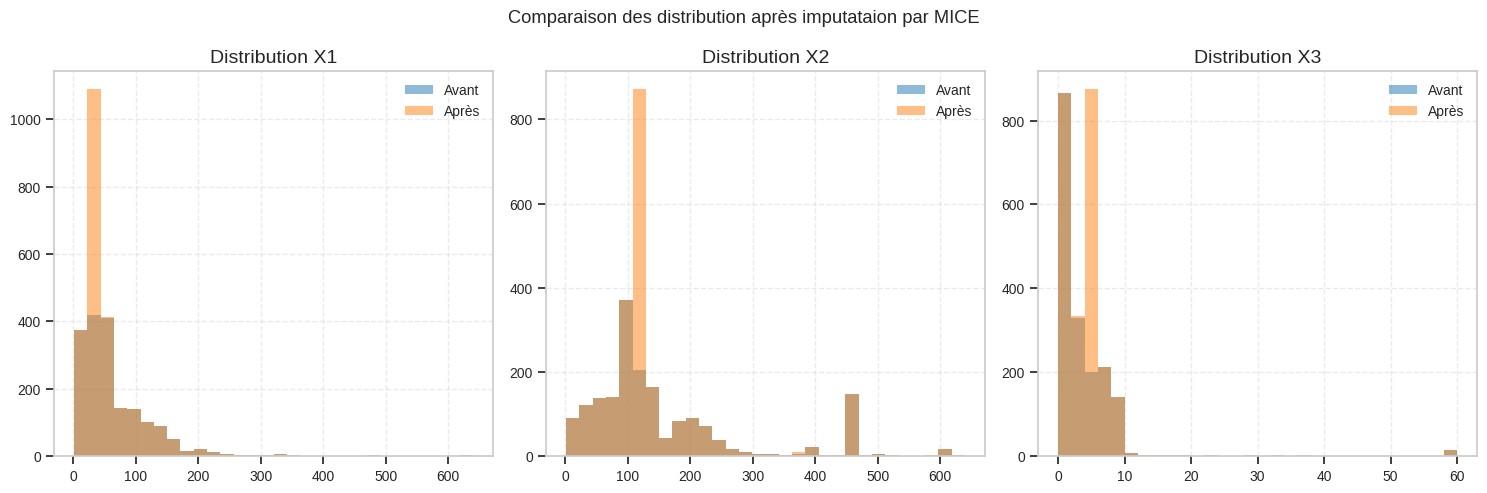

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 ligne, 3 colonnes

variables = ['X1', 'X2', 'X3']

for idx, var in enumerate(variables):
    axes[idx].hist(df_study[var].dropna(), alpha=0.5, label='Avant', bins=30)
    axes[idx].hist(df_imputed_mice[var].dropna(), alpha=0.5, label='Après', bins=30)
    axes[idx].set_title(f'Distribution {var}')
    axes[idx].legend()


fig.suptitle("Comparaison des distribution après imputataion par MICE")
plt.tight_layout()
# Ajustons le rectangle de la mise en page pour faire de la place au suptitle
#plt.subplots_adjust(top=0.9)
fig.savefig( FIGURES_DIR / "figures_notebook1"/ "pretraitement_avance" / "distribution_imputation.png", dpi=150)

plt.show()



### 5.1.4 Imputation par KNN

🔍 Recherche du k optimal pour KNN Imputer (avec outliers)
🔍 Recherche de la valeur optimale K pour l'imputation KNN
📊 Colonnes à évaluer      : ['X1', 'X2', 'X3']
🎯 Plage K à tester        : [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
🔄 Validation croisée      : 20 folds
📏 Métrique d'évaluation  : MSE
------------------------------------------------------------

🧮 Données utilisées pour le test : 1,780 lignes.

🔄 Test K= 3 → MSE: 1751.2006 (±1323.7758)

🔄 Test K= 5 → MSE: 1697.8708 (±1241.7767)

🔄 Test K= 7 → MSE: 1666.4421 (±1127.6153)

🔄 Test K= 9 → MSE: 1718.1506 (±1186.7729)

🔄 Test K=11 → MSE: 1734.6245 (±1206.3695)

🔄 Test K=13 → MSE: 1827.9044 (±1288.4269)

🔄 Test K=15 → MSE: 1876.9026 (±1278.1435)

🔄 Test K=17 → MSE: 1897.6304 (±1244.5724)

🔄 Test K=19 → MSE: 1946.4057 (±1244.5636)

🔄 Test K=21 → MSE: 2018.3827 (±1291.9752)

🔄 Test K=23 → MSE: 2074.0824 (±1340.0497)

🔄 Test K=25 → MSE: 2143.1838 (±1376.4413)

🔄 Test K=27 → MSE: 2189.3555 (±1401.7925)

🔄 Test K=29 → MSE

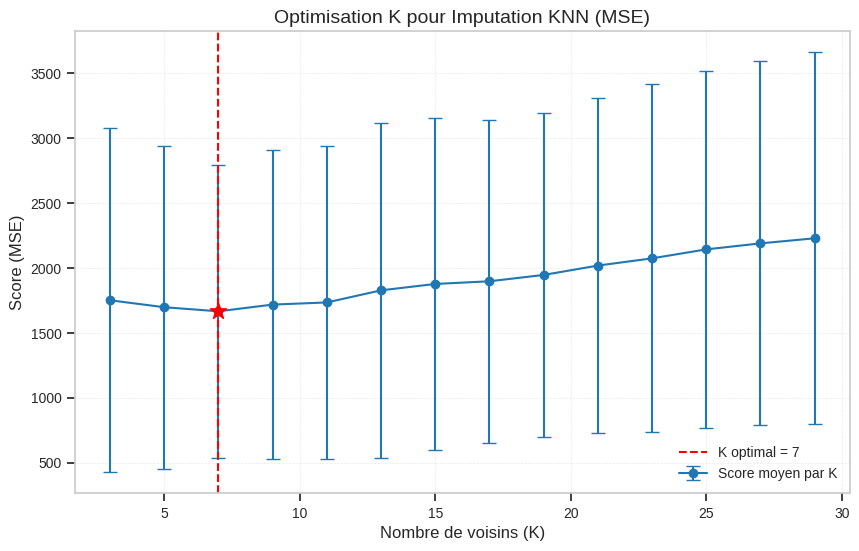


🎯 RÉSULTATS DE L'OPTIMISATION
🏆 K optimal              : 7
📊 Meilleur score (MSE)  : 1666.4421
⏱️  Temps de calcul        : 3.20s

✅ Le K optimal final est : 7
🔧 Début de l'imputation des valeurs manquantes
📊 Valeurs manquantes initiales: 2026
📊 Variables MAR à imputer: 3
   • X1: 674 valeurs manquantes
   • X2: 673 valeurs manquantes
   • X3: 679 valeurs manquantes
💾 Modèle d'imputation sauvegardé: /content/drive/MyDrive/projet_sta211/models/notebook1/knn/imputer_knn_k7.pkl

📊 Résumé de l'imputation:
   • Valeurs manquantes avant: 2026
   • Valeurs manquantes après: 0
💾 Données imputées sauvegardées: /content/drive/MyDrive/projet_sta211/data/processed/notebook1/df_imputed_knn_k7.csv
✅ Imputation terminée avec succès


In [ ]:
### 5.3.4 Imputation par KNN <a id="imputation-knn"></a>

from pathlib import Path
#from preprocessing.missing_values import handle_missing_values, find_optimal_k_v2

# 📁 Chemins de sauvegarde
processed_data_dir_knn = paths["DATA_PROCESSED"] / "notebook1"
# Update imputers_dir_knn to include the 'knn' subdirectory
imputers_dir_knn = paths["MODELS_DIR"] / "notebook1" / "knn"
imputers_dir_knn.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist

# 🔍 Recherche du k optimal pour KNN (avec outliers)
print("🔍 Recherche du k optimal pour KNN Imputer (avec outliers)")
features = ['X1', 'X2', 'X3']
df_sample = df_study[features].copy()

from modules.preprocessing.find_optimal_k import find_optimal_k_v2

results_knn = find_optimal_k_v2(
    df=df_study,
    columns_to_impute=features,
    k_range=range(3, 30, 2),
    cv_folds=20,
    sample_size=3000,
    verbose=True,
    random_state=42
)

optimal_k = results_knn['optimal_k']
print(f"\n✅ Le K optimal final est : {optimal_k}")

# ✅ Imputation sur les données avec KNN
df_imputed_knn = handle_missing_values(
    df=df_study.copy(deep=True),
    strategy="mixed_mar_mcar",
    mar_method='knn',
    knn_k=optimal_k,
    mar_cols=features,
    mcar_cols=[],
    processed_data_dir=processed_data_dir_knn,
    imputers_dir=imputers_dir_knn,  # ✅ Nouveau paramètre
    save_results=True,
    display_info=True
)

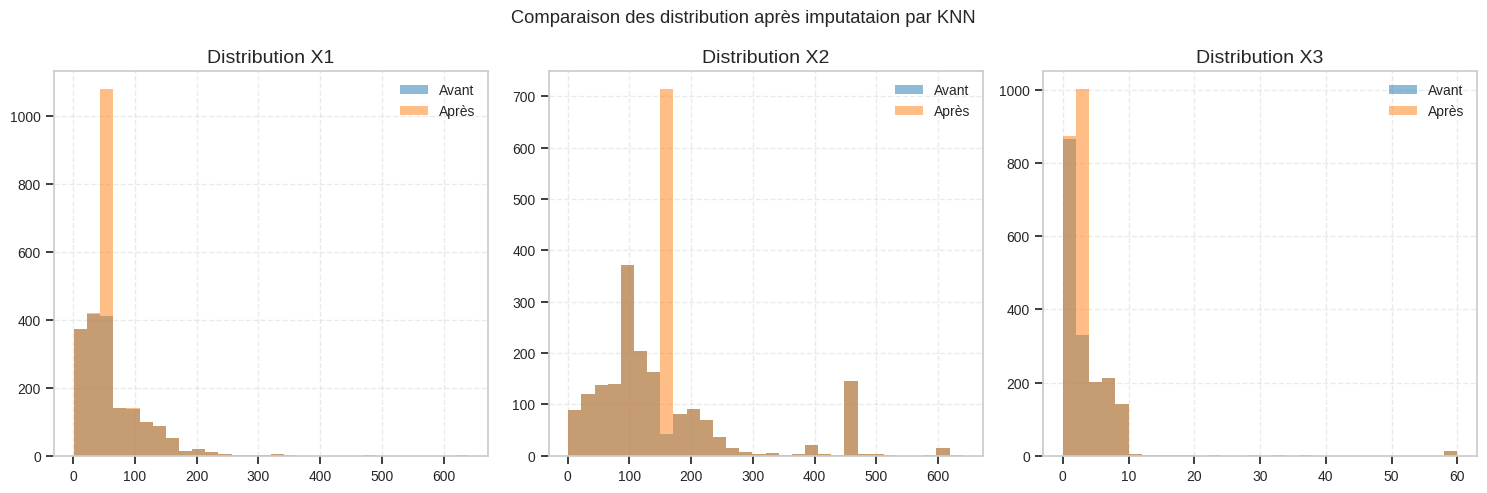

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 ligne, 3 colonnes

variables = ['X1', 'X2', 'X3']

for idx, var in enumerate(variables):
    axes[idx].hist(df_study[var].dropna(), alpha=0.5, label='Avant', bins=30)
    axes[idx].hist(df_imputed_knn[var], alpha=0.5, label='Après', bins=30)
    axes[idx].set_title(f'Distribution {var}')
    axes[idx].legend()

fig.suptitle("Comparaison des distribution après imputataion par KNN")
plt.tight_layout()

fig.savefig( FIGURES_DIR / "figures_notebook1"/ "pretraitement_avance" / "distribution_imputation_knn.png", dpi=150)

plt.show()

## 5.2 Transformation optimale mixte  

### 🔁 Optimisation des transformations de variables

Les variables `X1`, `X2` et `X3` présentent des asymétries importantes nécessitant une transformation adaptée : X1 (+2.529), X2 (+1.635), X3 (+7.063).

### **APPROCHE DÉVELOPPÉE**

Plutôt qu'une transformation uniforme, nous avons développé une **approche optimale mixte** basée sur l'analyse comparative :

| Variable | Box-Cox | Yeo-Johnson | **Choix optimal** |
|----------|---------|-------------|------------------|
| X1       | 0.009   | **0.006**   | **Yeo-Johnson** ✅ |
| X2       | 0.019   | **0.013**   | **Yeo-Johnson** ✅ |
| X3       | **0.021** | 0.155     | **Box-Cox** ✅ |

### 📊 **RÉSULTATS OBTENUS**

```python
from modules.preprocessing.transformation_optimale_mixte import appliquer_transformation_optimale
df_study_transformed = appliquer_transformation_optimale(df_study)
```

### **🎯 Performances finales :**
- **X1** : +2.529 → -0.006 (**amélioration : +2.523**)
- **X2** : +1.635 → +0.013 (**amélioration : +1.622**)
- **X3** : +7.063 → -0.021 (**amélioration : +7.042**)

**Amélioration totale : 11.187**

### **📈 Gains vs approches standards :**
- **+18.4% vs Box-Cox seul**
- **+77.0% vs Yeo-Johnson seul**

### ✅ **AVANTAGES**

1. **Performance optimale** : Chaque variable utilise sa meilleure transformation
2. **Modularité** : Code réutilisable via module dédié  
3. **Reproductibilité** : Transformateurs sauvegardés automatiquement
4. **Validation** : Comparaison systématique des approches

**Variables finales :** `X1_transformed`, `X2_transformed`, `X3_transformed`

---


In [ ]:
# Vérification rapide
print(f"📊 Valeurs manquantes après imputation knn : {df_imputed_knn.isnull().sum().sum()} total")
print(f"📊 Valeurs manquantes après imputation mice: {df_imputed_mice.isnull().sum().sum()} total")

📊 Valeurs manquantes après imputation knn : 0 total
📊 Valeurs manquantes après imputation mice: 0 total


### 5.2.1 Transformation sur les données imputées par MICE

In [ ]:
### 5.2.1 Transformation sur les données imputées par MICE (code)

# Import du module
from modules.preprocessing.transformation_optimale_mixte import appliquer_transformation_optimale


save_directory_mice = MODELS_DIR / "notebook1/mice/mice_transformers"

# Appelez la fonction en passant ce chemin
df_imputed_mice_transformed = appliquer_transformation_optimale(
    df=df_imputed_mice,
    models_dir=save_directory_mice
)

# 🎯 C'est tout ! nos nouvelles variables optimales sont prêtes :
# • X1_transformed (Yeo-Johnson - optimal)
# • X2_transformed (Yeo-Johnson - optimal)
# • X3_transformed (Box-Cox - optimal)

print("\n🚀 VARIABLES POUR LA MODÉLISATION:")
variables_optimales = ['X1_transformed', 'X2_transformed', 'X3_transformed']
print(f"Variables transformées: {variables_optimales}")

# Vérification rapide
print(f"\n📊 VÉRIFICATION:")
print(f"• Données originales: {df_study.shape}")
print(f"• Données transformées: {df_imputed_mice_transformed.shape}")
print(f"• Nouvelles colonnes ajoutées: {len(variables_optimales)}")


🔧 TRANSFORMATION OPTIMALE MIXTE

📊 Diagnostic initial:
  X1: Asymétrie = 3.041
  X2: Asymétrie = 2.086
  X3: Asymétrie = 8.214

🔄 Application Yeo-Johnson pour X1, X2...

🔄 Application Box-Cox pour X3...

📊 RAPPORT DE TRANSFORMATION :
  X1: Asymétrie avant=+3.041 → après=-0.002
  X2: Asymétrie avant=+2.086 → après=+0.058
  X3: Asymétrie avant=+8.214 → après=+0.031

💾 Transformateurs sauvegardés dans le dossier : /content/drive/MyDrive/projet_sta211/models/notebook1/mice/mice_transformers

✅ TRANSFORMATION OPTIMALE TERMINÉE
   Nouvelles colonnes disponibles : X1_transformed, X2_transformed, X3_transformed

🚀 VARIABLES POUR LA MODÉLISATION:
Variables transformées: ['X1_transformed', 'X2_transformed', 'X3_transformed']

📊 VÉRIFICATION:
• Données originales: (2459, 1559)
• Données transformées: (2459, 1562)
• Nouvelles colonnes ajoutées: 3


📊 Graphique de comparaison sauvegardé dans : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/transformation_comparison.png


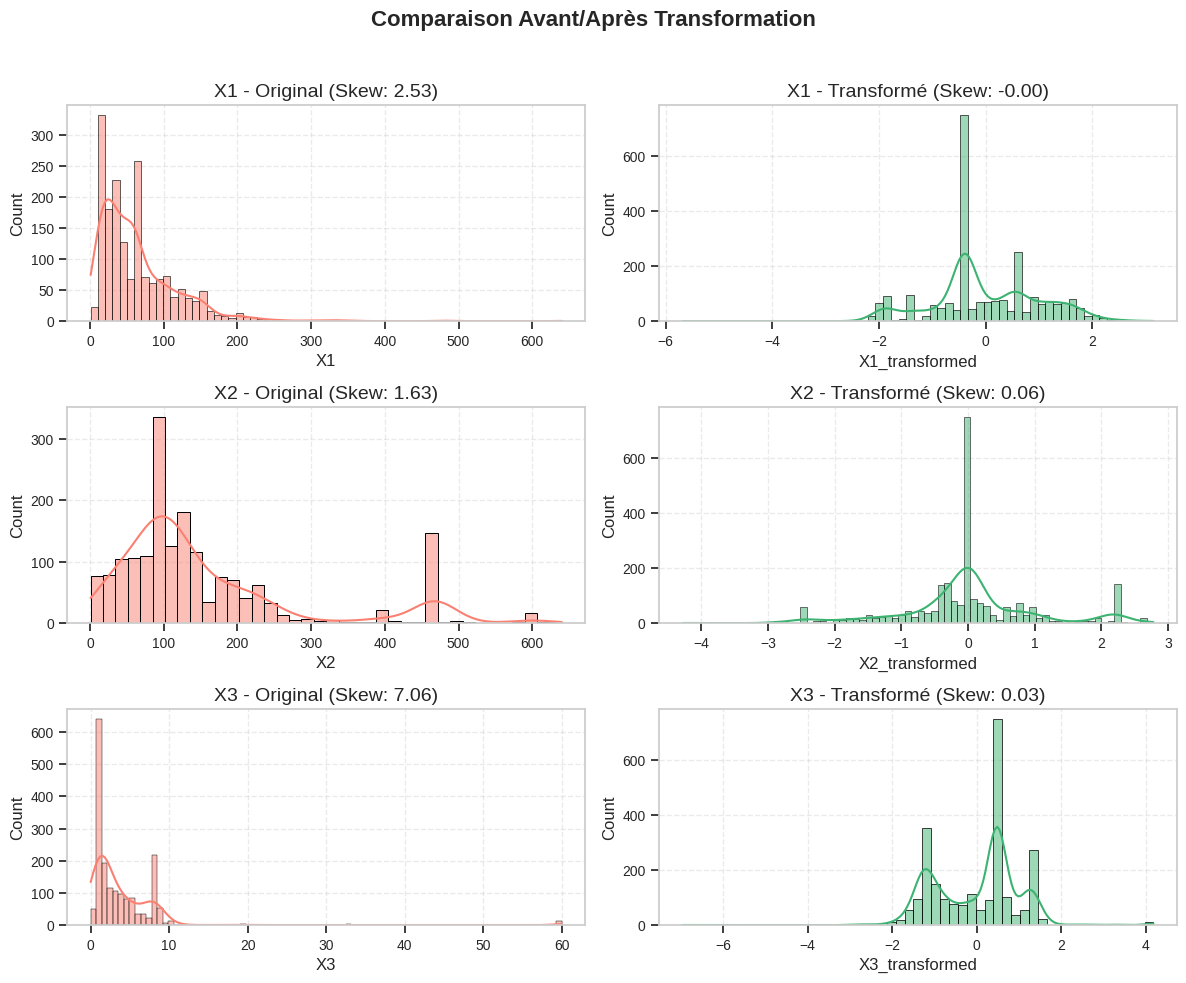

In [ ]:
from modules.preprocessing.transformation_optimale_mixte import generer_graphiques_comparaison

generer_graphiques_comparaison(df_study,
                               df_imputed_mice_transformed,
                               figures_dir = OUTPUTS_DIR / "figures/figures_notebook1/pretraitement_avance")

### 5.2.2 Transformation sur les données imputées par KNN

In [ ]:
### 5.2. Transformation sur les données imputées par KNN (code)

# Import du module
from modules.preprocessing.transformation_optimale_mixte import appliquer_transformation_optimale

save_directory_knn = MODELS_DIR / "notebook1/knn/knn_transformers"

# Appelez la fonction en passant ce chemin
df_imputed_knn_transformed = appliquer_transformation_optimale(
    df=df_imputed_knn,
    models_dir=save_directory_knn
)

# notre nouvelles variables optimales sont prêtes :
# • X1_transformed (Yeo-Johnson - optimal)
# • X2_transformed (Yeo-Johnson - optimal)
# • X3_transformed (Box-Cox - optimal)

print("\n🚀 VARIABLES POUR LA MODÉLISATION:")
variables_optimales = ['X1_trans', 'X2_trans', 'X3_trans']
print(f"Variables transformées: {variables_optimales}")

# Vérification rapide
print(f"\n📊 VÉRIFICATION:")
print(f"• Données originales: {df_study.shape}")
print(f"• Données transformées: {df_imputed_knn_transformed.shape}")
print(f"• Nouvelles colonnes ajoutées: {len(variables_optimales)}")


🔧 TRANSFORMATION OPTIMALE MIXTE

📊 Diagnostic initial:
  X1: Asymétrie = 2.965
  X2: Asymétrie = 1.917
  X3: Asymétrie = 8.293

🔄 Application Yeo-Johnson pour X1, X2...

🔄 Application Box-Cox pour X3...

📊 RAPPORT DE TRANSFORMATION :
  X1: Asymétrie avant=+2.965 → après=+0.011
  X2: Asymétrie avant=+1.917 → après=+0.062
  X3: Asymétrie avant=+8.293 → après=+0.029

💾 Transformateurs sauvegardés dans le dossier : /content/drive/MyDrive/projet_sta211/models/notebook1/knn/knn_transformers

✅ TRANSFORMATION OPTIMALE TERMINÉE
   Nouvelles colonnes disponibles : X1_transformed, X2_transformed, X3_transformed

🚀 VARIABLES POUR LA MODÉLISATION:
Variables transformées: ['X1_trans', 'X2_trans', 'X3_trans']

📊 VÉRIFICATION:
• Données originales: (2459, 1559)
• Données transformées: (2459, 1562)
• Nouvelles colonnes ajoutées: 3


📊 Graphique de comparaison sauvegardé dans : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/transformation_comparison.png


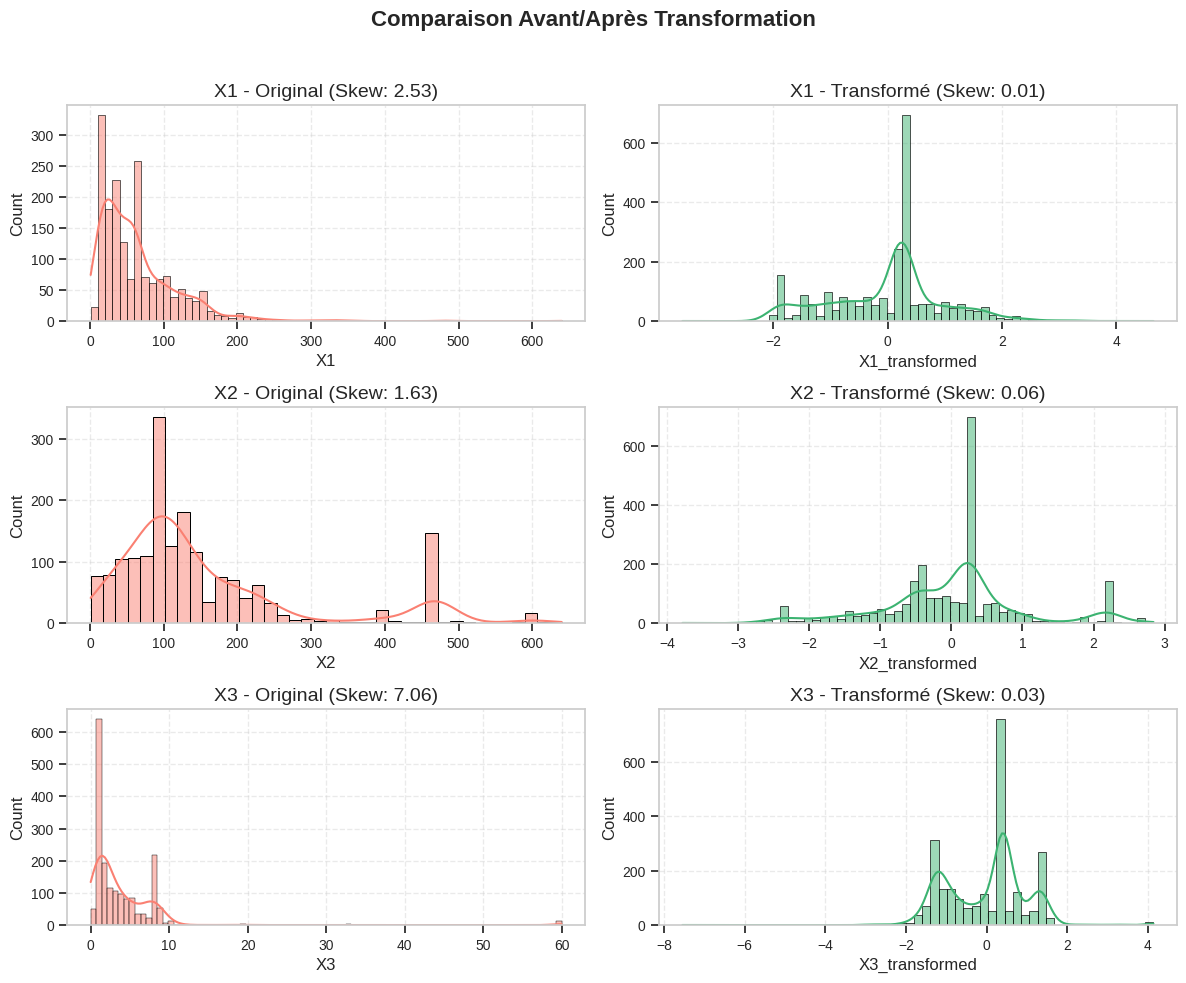

In [ ]:
from modules.preprocessing.transformation_optimale_mixte import generer_graphiques_comparaison

generer_graphiques_comparaison(df_study,
                               df_imputed_knn_transformed,
                               figures_dir = OUTPUTS_DIR / "figures/figures_notebook1/pretraitement_avance")


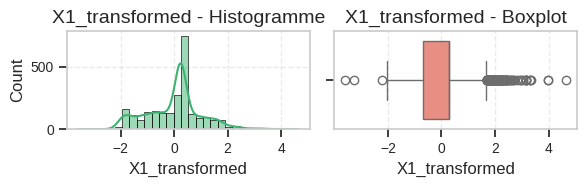

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X1_transformed_distribution_boxplot.png


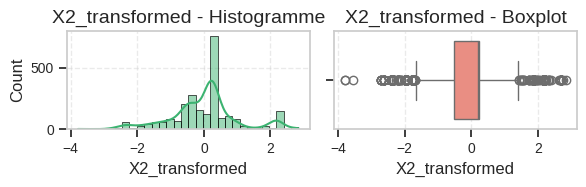

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X2_transformed_distribution_boxplot.png


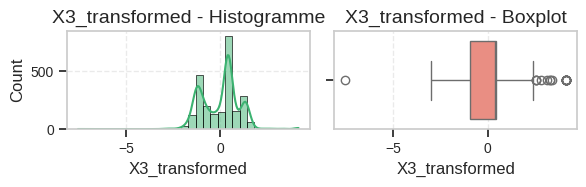

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X3_transformed_distribution_boxplot.png


In [ ]:

# ✅ Liste des variables transformées
transformed_vars = ["X1_transformed", "X2_transformed", "X3_transformed"]

# 📁 Dossier de sauvegarde
output_dir = FIGURES_DIR / "figures_notebook1"/ 'pretraitement_avance'
output_dir.mkdir(parents=True, exist_ok=True)

# 🔁 Génération et sauvegarde des figures
for col in transformed_vars:
    fig, ax = plt.subplots(1, 2, figsize=(6, 2))

    # Histogramme + KDE
    sns.histplot(x=df_imputed_knn_transformed[col], bins=30, kde=True, ax=ax[0], color="mediumseagreen")
    ax[0].set_title(f"{col} - Histogramme")
    ax[0].set_xlabel(col)

    # Boxplot
    sns.boxplot(x=df_imputed_knn_transformed[col], ax=ax[1], color="salmon")
    ax[1].set_title(f"{col} - Boxplot")

    plt.tight_layout()

    # 💾 Sauvegarde
    fig_path = output_dir / f"{col}_distribution_boxplot.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Figure sauvegardée : {fig_path}")

## 5.3 Traitement des Outliers (Capping)  


#### 🎯 **Objectifs :**
-   Identifier les observations extrêmes sur les données transformées.
-   **Neutraliser l'influence** de ces outliers **sans supprimer d'observations**, afin de conserver toute l'information du jeu de données.

#### 🛠️ **Méthode :**
-   Utilisation de la règle de l’IQR (Interquartile Range) pour définir des seuils acceptables.
-   Application sur les colonnes déjà transformées : `X1_transformed`, `X2_transformed`, `X3_transformed`.
-   **Capping (plafonnement)** : Remplacement des valeurs situées au-delà des seuils par les valeurs des seuils eux-mêmes (`Q1 - 1.5*IQR` et `Q3 + 1.5*IQR`).

#### 📉 **Impact attendu :**
-   Réduction drastique de l'effet des valeurs extrêmes sur les modèles.
-   **Aucune perte de données**, ce qui est crucial pour préserver les informations de la classe minoritaire.
-   Stabilisation de la variance des variables avant la modélisation.

#### ✅ **Étapes suivantes :**
1.  Calcul des limites (seuils) via l'IQR pour chaque variable transformée.
2.  Comptage des outliers qui seront "cappés".
3.  Application de la fonction `np.clip` pour plafonner les valeurs.
4.  Visualisation de la distribution avant et après le capping pour confirmer le succès de l'opération.

In [ ]:
import numpy as np
import joblib

def apply_capping_and_save(df, cols_to_cap, save_path, display_info=True):
    """
    Applique le capping (Winsorizing) sur les colonnes spécifiées d'un DataFrame
    et sauvegarde les paramètres dans un fichier pickle.

    Args:
        df (pd.DataFrame): DataFrame source.
        cols_to_cap (list): Liste des noms de colonnes à capper.
        save_path (Path): Chemin complet vers le fichier pickle.
        display_info (bool): Active ou désactive l'affichage des logs.

    Returns:
        pd.DataFrame: Nouveau DataFrame avec capping appliqué.
    """
    capped_df = df.copy()
    capping_params = {}

    for col in cols_to_cap:
        Q1 = capped_df[col].quantile(0.25)
        Q3 = capped_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        capping_params[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

        outliers_low = (capped_df[col] < lower_bound).sum()
        outliers_high = (capped_df[col] > upper_bound).sum()

        capped_df[col] = np.clip(capped_df[col], lower_bound, upper_bound)

        if display_info:
            print(f"\n--- Variable : {col} ---")
            print(f"  Limites IQR : [{lower_bound:.3f}, {upper_bound:.3f}]")
            print(f"  Outliers détectés : {outliers_low + outliers_high} ({outliers_low} bas, {outliers_high} hauts)")
            print("  ✅ Capping appliqué.")

    joblib.dump(capping_params, save_path)

    if display_info:
        print(f"\n🚀 Capping terminé et paramètres sauvegardés dans {save_path}")

    return capped_df


In [ ]:
import numpy as np
import joblib

print("Application du Capping (Winsorizing) sur les variables imputées par MICE et transformées")

# Update save_path to include the 'mice' subdirectory
mice_capping_save_path = paths["MODELS_DIR"] / "notebook1" / "mice" / "capping_params_mice.pkl"
mice_capping_save_path.parent.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist

df_mice_capped = apply_capping_and_save(
    df=df_imputed_mice_transformed,
    cols_to_cap=['X1_transformed', 'X2_transformed', 'X3_transformed'],
    save_path=mice_capping_save_path
)

Application du Capping (Winsorizing) sur les variables imputées par MICE et transformées

--- Variable : X1_transformed ---
  Limites IQR : [-1.866, 2.057]
  Outliers détectés : 123 (88 bas, 35 hauts)
  ✅ Capping appliqué.

--- Variable : X2_transformed ---
  Limites IQR : [-1.415, 1.258]
  Outliers détectés : 423 (193 bas, 230 hauts)
  ✅ Capping appliqué.

--- Variable : X3_transformed ---
  Limites IQR : [-3.139, 2.643]
  Outliers détectés : 19 (1 bas, 18 hauts)
  ✅ Capping appliqué.

🚀 Capping terminé et paramètres sauvegardés dans /content/drive/MyDrive/projet_sta211/models/notebook1/mice/capping_params_mice.pkl


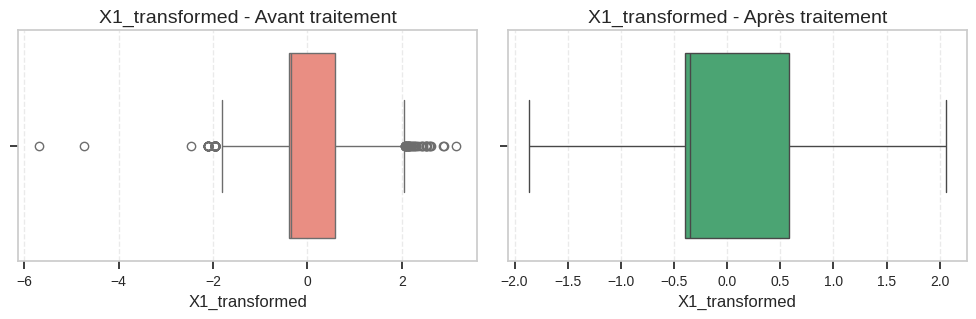

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X1_transformed_outliers_comparison.png


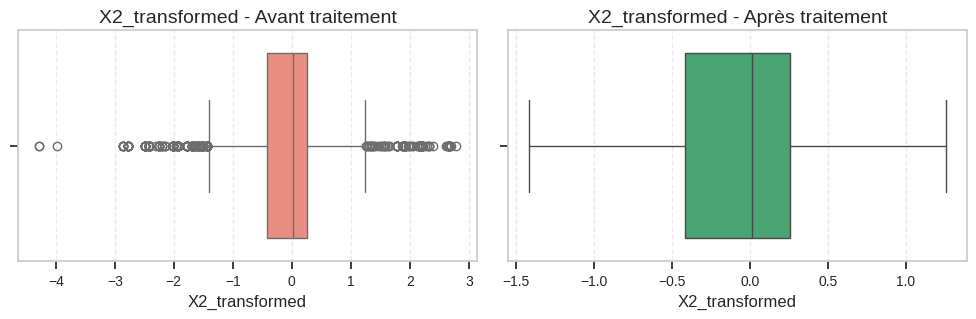

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X2_transformed_outliers_comparison.png


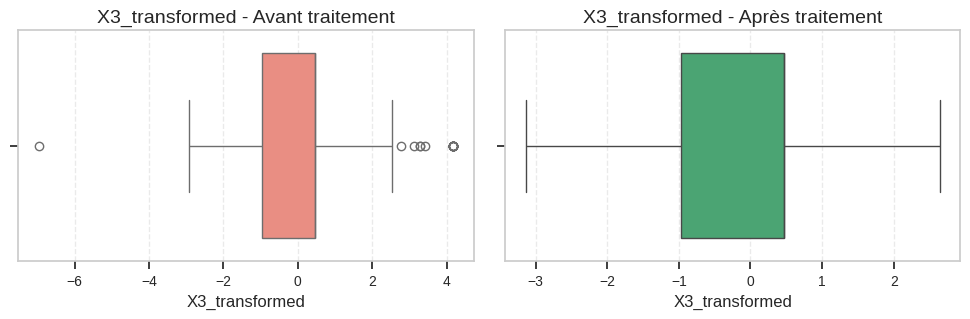

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X3_transformed_outliers_comparison.png


In [ ]:
## 📊 Visualisation comparative avant/après traitement des outliers

from exploration.visualization import plot_outlier_comparison


transformed_cols = ['X1_transformed', 'X2_transformed', 'X3_transformed']
# ✅ Comparaison visuelle avant / après (X1_trans, X2_trans, X3_trans)
plot_outlier_comparison(
    df_before=df_imputed_mice_transformed,
    df_after=df_mice_capped,
    cols=transformed_cols,
    output_dir=FIGURES_DIR / "figures_notebook1" / "pretraitement_avance",
    show=True
)


In [ ]:
import numpy as np
import joblib

print("🔧 Application du Capping (Winsorizing) sur les variables imputées par KNN et transformées")
# Update save_path to include the 'knn' subdirectory
knn_capping_save_path = paths["MODELS_DIR"] / "notebook1" / "knn" / "capping_params_knn.pkl"
knn_capping_save_path.parent.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist

df_knn_capped = apply_capping_and_save(
    df=df_imputed_knn_transformed,
    cols_to_cap=['X1_transformed', 'X2_transformed', 'X3_transformed'],
    save_path=knn_capping_save_path
)

🔧 Application du Capping (Winsorizing) sur les variables imputées par KNN et transformées

--- Variable : X1_transformed ---
  Limites IQR : [-2.089, 1.677]
  Outliers détectés : 115 (3 bas, 112 hauts)
  ✅ Capping appliqué.

--- Variable : X2_transformed ---
  Limites IQR : [-1.682, 1.402]
  Outliers détectés : 364 (151 bas, 213 hauts)
  ✅ Capping appliqué.

--- Variable : X3_transformed ---
  Limites IQR : [-3.042, 2.525]
  Outliers détectés : 22 (1 bas, 21 hauts)
  ✅ Capping appliqué.

🚀 Capping terminé et paramètres sauvegardés dans /content/drive/MyDrive/projet_sta211/models/notebook1/knn/capping_params_knn.pkl


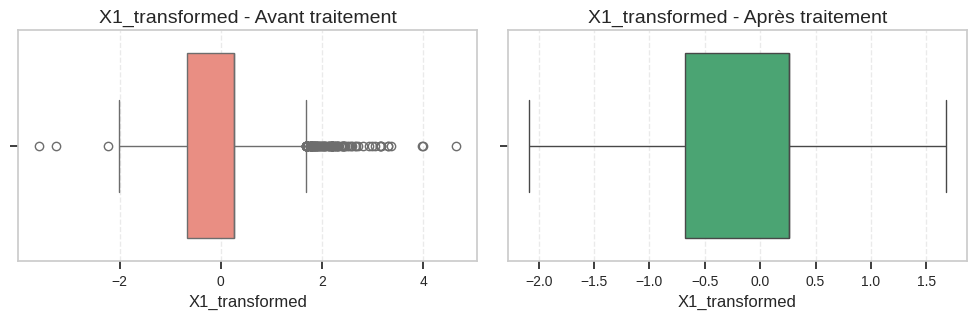

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X1_transformed_outliers_comparison.png


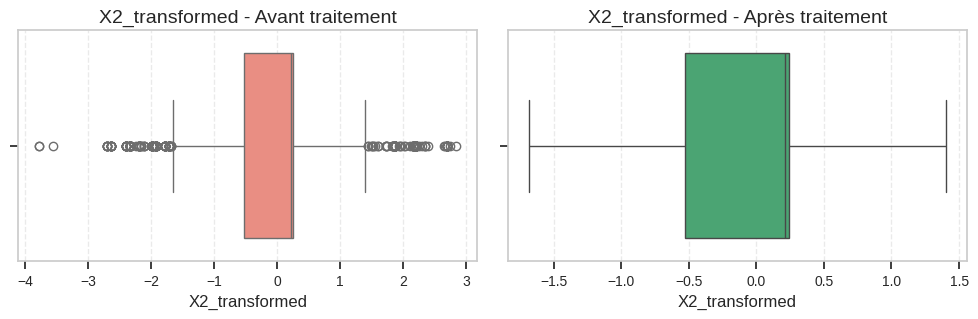

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X2_transformed_outliers_comparison.png


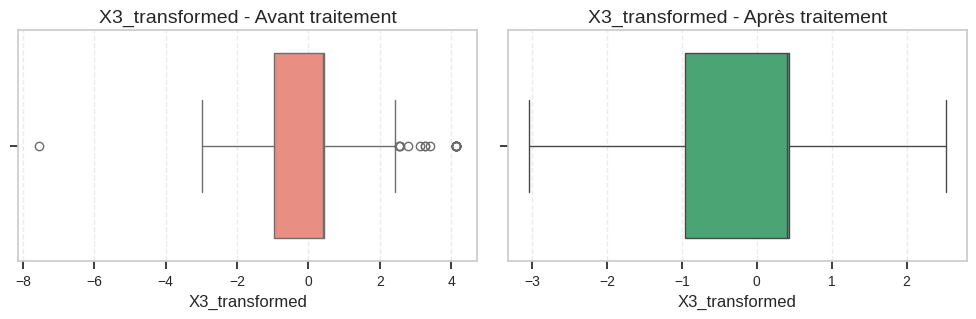

✅ Figure sauvegardée : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook1/pretraitement_avance/X3_transformed_outliers_comparison.png


In [ ]:

## 📊 Visualisation comparative avant/après traitement des outliers

from exploration.visualization import plot_outlier_comparison


transformed_cols = ['X1_transformed', 'X2_transformed', 'X3_transformed']
# ✅ Comparaison visuelle avant / après (X1_trans, X2_trans, X3_trans)
plot_outlier_comparison(
    df_before=df_imputed_knn_transformed,
    df_after=df_knn_capped,
    cols=transformed_cols,
    output_dir=FIGURES_DIR / "figures_notebook1" / "pretraitement_avance",
    show=True
)


In [ ]:

# Vérification rapide
print(f"📊 Valeurs manquantes dans les données outliers traités (données knn) : {df_knn_capped.isnull().sum().sum()} total")


print(f"📊 Valeurs manquantes dans les données outliers traités (MICE) : {df_mice_capped.isnull().sum().sum()} total")

📊 Valeurs manquantes dans les données outliers traités (données knn) : 0 total
📊 Valeurs manquantes dans les données outliers traités (MICE) : 0 total


## 5.4 Détection et traitement des variables collinéaires  


A partir de cette section on va différencier 4 jeux de données:
- Données imputées par mice et traitement des outliers: **`df_mice_no_outliers = df_mice_capped.copy(deep=True)`**
- Données imputées par knn et traitement des outliers: **`df_knn_no_outliers = df_knn_capped.copy(deep=True)`**
- Données imputées par mice sans traitement des outliers: **`df_mice_with_outliers = df_imputed_mice_transformed.copy(deep=True)**`
- Données imputées par knn sans traitement des outliers: **`df_knn_with_outliers = df_imputed_knn_transformed.copy(deep=True)`**

In [ ]:
df_mice_no_outliers = df_mice_capped.copy(deep=True)
df_knn_no_outliers = df_knn_capped.copy(deep=True)
df_mice_with_outliers = df_imputed_mice_transformed.copy(deep=True)
df_knn_with_outliers = df_imputed_knn_transformed.copy(deep=True)

In [ ]:
print(df_knn_no_outliers.shape)
print(df_knn_with_outliers.shape)

(2459, 1562)
(2459, 1562)


In [ ]:
## 5.4.1 Détection et traitement des variables collinéaires <a id="detection-et-traitement-des-variables-collineaires"></a>

from preprocessing.final_preprocessing import find_highly_correlated_groups

datasets = {
    "mice_no_outliers": df_mice_no_outliers,
    "knn_no_outliers": df_knn_no_outliers,
    "mice_with_outliers": df_mice_with_outliers,
    "knn_with_outliers": df_knn_with_outliers
}

correlated_results = {}

for name, df in datasets.items():
    print(f"\n🔍 Détection collinéarité sur : {name}")

    save_path = FIGURES_DIR / "figures_notebook1" / "pretraitement_avance" / f"correlation_heatmap_collinearity_{name}.png"

    result = find_highly_correlated_groups(
        df=df,
        threshold=0.95,
        exclude_cols=['y', 'X4'],
        show_plot=False,
        save_path=save_path
    )

    correlated_results[name] = result

    print(f" {len(result['groups'])} groupes détectés pour {name}")
    print(f" {len(result['to_drop'])} variables à supprimer pour {name}")



🔍 Détection collinéarité sur : mice_no_outliers
 902 groupes détectés pour mice_no_outliers
 3506 variables à supprimer pour mice_no_outliers

🔍 Détection collinéarité sur : knn_no_outliers
 902 groupes détectés pour knn_no_outliers
 3506 variables à supprimer pour knn_no_outliers

🔍 Détection collinéarité sur : mice_with_outliers
 902 groupes détectés pour mice_with_outliers
 3506 variables à supprimer pour mice_with_outliers

🔍 Détection collinéarité sur : knn_with_outliers
 902 groupes détectés pour knn_with_outliers
 3506 variables à supprimer pour knn_with_outliers


## 5.5 Suppression des variables collinéaires

In [ ]:
from preprocessing.final_preprocessing import apply_collinearity_filter

print("🧹 Suppression des variables fortement corrélées")
print("=" * 60)

# Le chemin de base ne change pas
base_models_dir = paths["MODELS_DIR"] / "notebook1"

filtered_datasets = {}
for name, df in datasets.items():
    print(f"\nTraitement des données : {name}")

    cols_to_drop = correlated_results[name]['to_drop']

    # L'appel à la fonction est maintenant beaucoup plus propre !
    df_filtered = apply_collinearity_filter(
        df=df,
        cols_to_drop=cols_to_drop,
        imputation_method='mice' if 'mice' in name else 'knn',
        models_dir=base_models_dir  # On passe juste le dossier de base
    )

    filtered_datasets[name] = df_filtered


🧹 Suppression des variables fortement corrélées

Traitement des données : mice_no_outliers
💾 Liste des colonnes sauvegardée dans : mice/cols_to_drop_corr.pkl
✅ Colonnes supprimées : 3506
📏 Dimensions finales : (2459, 658)

Traitement des données : knn_no_outliers
💾 Liste des colonnes sauvegardée dans : knn/cols_to_drop_corr.pkl
✅ Colonnes supprimées : 3506
📏 Dimensions finales : (2459, 658)

Traitement des données : mice_with_outliers
💾 Liste des colonnes sauvegardée dans : mice/cols_to_drop_corr.pkl
✅ Colonnes supprimées : 3506
📏 Dimensions finales : (2459, 658)

Traitement des données : knn_with_outliers
💾 Liste des colonnes sauvegardée dans : knn/cols_to_drop_corr.pkl
✅ Colonnes supprimées : 3506
📏 Dimensions finales : (2459, 658)


## 5.6 Sauvegarde des datasets filtrés  



In [ ]:
print("💾 Sauvegarde des jeux de données dans des dossiers spécifiques (KNN/MICE)")
print("=" * 70)

from pathlib import Path

# ✅ Dossier de base du notebook
base_notebook_dir = paths["DATA_PROCESSED"] / "notebook1"

# ✅ Sauvegarde automatique en créant la structure souhaitée
for name, df_filtered in filtered_datasets.items():

    # Détermine la méthode d'imputation en fonction du nom du dataset
    if 'mice' in name.lower():
        imputation_method = 'mice'
    elif 'knn' in name.lower():
        imputation_method = 'knn'
    else:
        imputation_method = 'other'

    # Construit le chemin de sauvegarde avec la structure souhaitée
    # Ex: .../notebook1/mice/datasets_filtered_final/
    output_dir = base_notebook_dir / imputation_method / "datasets_filtered_final"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Définit le chemin complet du fichier et sauvegarde
    save_path = output_dir / f"df_{name}_filtered.csv"
    df_filtered.to_csv(save_path, index=False)

    print(f"✅ Fichier sauvegardé : {imputation_method}/datasets_filtered_final/{save_path.name}")

print("\n✅ Toutes les versions filtrées ont été sauvegardées avec succès.")

💾 Sauvegarde des jeux de données dans des dossiers spécifiques (KNN/MICE)
✅ Fichier sauvegardé : mice/datasets_filtered_final/df_mice_no_outliers_filtered.csv
✅ Fichier sauvegardé : knn/datasets_filtered_final/df_knn_no_outliers_filtered.csv
✅ Fichier sauvegardé : mice/datasets_filtered_final/df_mice_with_outliers_filtered.csv
✅ Fichier sauvegardé : knn/datasets_filtered_final/df_knn_with_outliers_filtered.csv

✅ Toutes les versions filtrées ont été sauvegardées avec succès.


## 5.7 Ingénierie de caractéristiques (Feature Engineering)  

#### 🤔 **Pourquoi cette étape ?**
Notre analyse exploratoire (EDA) et la nature même de nos données (dimensions géométriques d'images) suggèrent fortement que les relations entre les variables continues (`X1`, `X2`, `X3`) et la cible (`y`) ne sont probablement **pas linéaires**.

#### 🎯 **Hypothèses basées sur l'EDA :**
1.  **L'interaction est plus prédictive :** Il est plus probable que la **surface** d'un élément (approximée par `X1 * X2`) ou son **volume** (`X1 * X2 * X3`) soient de meilleurs prédicteurs qu'une dimension seule.
2.  **La relation est non-linéaire :** L'effet d'une augmentation de la largeur d'une image n'est peut-être pas constant. Il pourrait avoir un impact quadratique (`X2^2`), signifiant que passer de 100 à 110 pixels de large n'a pas le même effet que de passer de 500 à 510.

#### 🛠️ **Méthode :**
Pour tester ces hypothèses, nous allons utiliser `PolynomialFeatures` de Scikit-learn. C'est la méthode standard pour générer systématiquement des termes d'interaction et des termes polynomiaux, permettant ainsi à nos modèles (même linéaires) de capturer ces relations complexes.

#### 📉 **Impact attendu :**
-   **Augmentation de la performance des modèles** en leur fournissant des caractéristiques plus expressives.
-   **Création d'un jeu de données plus riche** pour l'étape finale de sélection de caractéristiques, qui se chargera de ne garder que les termes réellement utiles.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import joblib

print("🔧 Application de l'ingénierie de caractéristiques (Feature Engineering) sur les 4 jeux de données")

continuous_cols_clean = ['X1_transformed', 'X2_transformed', 'X3_transformed']

# Dictionnaire pour stocker les versions finales
engineered_datasets = {}

# Boucle automatique sur les 4 jeux de données filtrés
for name, df in filtered_datasets.items():
    print(f"\n➡️ Traitement pour : {name}")

    df_continuous = df[continuous_cols_clean]
    other_cols = [col for col in df.columns if col not in continuous_cols_clean]
    df_others = df[other_cols]

    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    poly_features = poly.fit_transform(df_continuous)

    # Determine the correct subdirectory for saving the transformer
    if 'mice' in name:
        transformer_dir = paths["MODELS_DIR"] / "notebook1" / "mice"
    elif 'knn' in name:
        transformer_dir = paths["MODELS_DIR"] / "notebook1" / "knn"
    else:
        transformer_dir = paths["MODELS_DIR"] / "notebook1" # Default if neither is in name

    transformer_dir.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist
    transformer_path = transformer_dir / f"poly_transformer_{name}.pkl"
    joblib.dump(poly, transformer_path)
    print(f"✅ Transformateur PolynomialFeatures sauvegardé : {transformer_path.name}")

    # Création du DataFrame avec les nouvelles caractéristiques
    poly_feature_names = poly.get_feature_names_out(continuous_cols_clean)
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    # Combinaison finale
    df_engineered = pd.concat([df_others, df_poly], axis=1)

    print(f"   Nombre de caractéristiques avant : {len(df.columns)}")
    print(f"   Nombre de caractéristiques après : {len(df_engineered.columns)}")

    engineered_datasets[name] = df_engineered

    print("✅ Ingénierie terminée pour :", name)

print("\n🎯 Tous les datasets ont été transformés et sauvegardés avec leur transformer associé.")

🔧 Application de l'ingénierie de caractéristiques (Feature Engineering) sur les 4 jeux de données

➡️ Traitement pour : mice_no_outliers
✅ Transformateur PolynomialFeatures sauvegardé : poly_transformer_mice_no_outliers.pkl
   Nombre de caractéristiques avant : 658
   Nombre de caractéristiques après : 664
✅ Ingénierie terminée pour : mice_no_outliers

➡️ Traitement pour : knn_no_outliers
✅ Transformateur PolynomialFeatures sauvegardé : poly_transformer_knn_no_outliers.pkl
   Nombre de caractéristiques avant : 658
   Nombre de caractéristiques après : 664
✅ Ingénierie terminée pour : knn_no_outliers

➡️ Traitement pour : mice_with_outliers
✅ Transformateur PolynomialFeatures sauvegardé : poly_transformer_mice_with_outliers.pkl
   Nombre de caractéristiques avant : 658
   Nombre de caractéristiques après : 664
✅ Ingénierie terminée pour : mice_with_outliers

➡️ Traitement pour : knn_with_outliers
✅ Transformateur PolynomialFeatures sauvegardé : poly_transformer_knn_with_outliers.pkl
   

## 5.8 Sélection des caractéristiques (Feature Selection)

#### 🤔 **Pourquoi cette étape finale ?**
Nous disposons maintenant de **664 caractéristiques**. C'est un excellent ensemble, riche et nettoyé, mais il contient probablement encore du bruit. Pour construire le modèle le plus robuste et performant possible, nous devons faire une dernière sélection pour ne garder que les variables ayant le plus fort pouvoir prédictif.

#### 🎯 **Objectif :**
-   Réduire la dimensionnalité de 664 à un nombre plus gérable (ex: **k=200**).
-   Diminuer le risque de surapprentissage (overfitting) et le temps d'entraînement.
-   Isoler les caractéristiques les plus influentes pour la prédiction de publicités.

#### 🛠️ **Méthode :**
-   Nous allons de nouveau utiliser `SelectKBest` de Scikit-learn, qui est une méthode "filtre" rapide et efficace.
-   **Score `f_classif` (ANOVA F-value)** : Ce test statistique est bien adapté car il mesure la dépendance entre chaque variable (qu'elle soit continue ou binaire) et la cible de classification.

#### 📉 **Impact attendu :**
-   Un jeu de données final, **hautement prédictif et de taille optimale**, prêt à être utilisé dans notre notebook de modélisation pour obtenir le meilleur F1-score possible.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
import pandas as pd
import joblib

print("🚀 Recherche automatique du k optimal et sélection finale pour les 4 jeux de données")
print("=" * 60)

selected_datasets = {}

for name, df in engineered_datasets.items():
    print(f"\n🔍 Traitement pour : {name}")

    X = df.drop(columns=['y'])
    y = df['y']

    pipeline = Pipeline([
        ('selector', SelectKBest(score_func=f_classif)),
        ('model', LogisticRegression(solver='liblinear', random_state=42))
    ])

    param_grid = {'selector__k': [200, 250, 300, 400, 500, 600, 664]}

    cv_strategy = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=cv_strategy,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    best_k = grid_search.best_params_['selector__k']
    print(f"✅ Meilleur k pour {name} : {best_k}")

    selector = SelectKBest(score_func=f_classif, k=best_k)
    selector.fit(X, y)

    selected_cols_mask = selector.get_support()
    selected_cols = X.columns[selected_cols_mask]

    # ✅ Forcer la présence de X4 et y dans final_cols
    required_cols = ['X4', 'y']
    final_cols = list(set(selected_cols).union(set(required_cols)).intersection(df.columns))

    df_final = df[final_cols].copy()
    df_final = df_final.rename(columns={"y": "outcome"})

    selected_datasets[name] = df_final

# Nettoyage après sélection complète
print("\n🧹 Nettoyage : suppression des variables d'origine avant sauvegarde finale")
cols_to_remove = ['X1', 'X2', 'X3']  # X4 n'est pas inclus ici

for name, df in selected_datasets.items():
    cols_in_df = [col for col in cols_to_remove if col in df.columns]
    if cols_in_df:
        print(f"   → {name}: suppression de {cols_in_df}")
        df.drop(columns=cols_in_df, inplace=True)
    else:
        print(f"   → {name}: aucune variable d'origine à supprimer")

    selected_datasets[name] = df

    output_path = paths["DATA_PROCESSED"] / "notebook1/final_data_for_modeling" / f"df_final_for_modeling_{name}.csv"
    output_path.parent.mkdir(parents=True, exist_ok=True) # Ensure directory exists
    df.to_csv(output_path, index=False)
    print(f"💾 Jeu de données final sauvegardé : {output_path}")

    # Determine the correct subdirectory for saving the selector
    if 'mice' in name:
        selector_dir = paths["MODELS_DIR"] / "notebook1" / "mice"
    elif 'knn' in name:
        selector_dir = paths["MODELS_DIR"] / "notebook1" / "knn"
    else:
        selector_dir = paths["MODELS_DIR"] / "notebook1" # Default if neither is in name

    selector_dir.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist
    selector_path = selector_dir / f"selector_{name}.pkl"
    joblib.dump(selector, selector_path)
    print(f"💾 Sélecteur sauvegardé : {selector_path}")

print("\n✅ Processus complet terminé pour les 4 jeux de données. Nous pouvons passer à la modélisation.")

🚀 Recherche automatique du k optimal et sélection finale pour les 4 jeux de données

🔍 Traitement pour : mice_no_outliers
Fitting 20 folds for each of 7 candidates, totalling 140 fits
✅ Meilleur k pour mice_no_outliers : 600

🔍 Traitement pour : knn_no_outliers
Fitting 20 folds for each of 7 candidates, totalling 140 fits
✅ Meilleur k pour knn_no_outliers : 600

🔍 Traitement pour : mice_with_outliers
Fitting 20 folds for each of 7 candidates, totalling 140 fits
✅ Meilleur k pour mice_with_outliers : 300

🔍 Traitement pour : knn_with_outliers
Fitting 20 folds for each of 7 candidates, totalling 140 fits
✅ Meilleur k pour knn_with_outliers : 400

🧹 Nettoyage : suppression des variables d'origine avant sauvegarde finale
   → mice_no_outliers: suppression de ['X1', 'X2', 'X3']
💾 Jeu de données final sauvegardé : /content/drive/MyDrive/projet_sta211/data/processed/notebook1/final_data_for_modeling/df_final_for_modeling_mice_no_outliers.csv
💾 Sélecteur sauvegardé : /content/drive/MyDrive/pro


# 6. Conclusion du prétraitement <a id="conclusion-pretraitement"></a>


🎯 Le processus de prétraitement des données est désormais terminé avec succès.

🧩 Étapes réalisées :
- Nettoyage et standardisation de la cible
- Analyse complète de la structure du dataset
- Transformation Yeo-Johnson et box-cox des variables continues
- Détection et traitement des outliers
- Imputation multivariée (KNN et MICE) avec validation croisée
- Réduction de la colinéarité
- Génération automatique des datasets finaux en selectinnant les variables finales

📦 Datasets finaux disponibles :
- MICE avec et sans outliers
- KNN avec et sans outliers

✅ Prêt pour la phase de modélisation supervisée avec évaluation du F1-score.


------------------------ Fin du notebook 1 ----------------------------------